In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd
import copy

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/__init__.py:202: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate bi

In [2]:
import smart
import coronagraph as cg
import pandas as pd

/Users/Jake/Projects/Packages/photochem_smart/smart/extra/gas_info.py:67: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  'mass', 'minwn', 'maxwn', 'n'])
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _bspl
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:94: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ckdtree import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .qhull import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/_spherical_voronoi.py:18: RuntimeWarning: numpy.dtype size 

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

In [4]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [5]:
# ASSUMPTIONS
wantSNR      = 8.5       # Desired SNR in each spectral element
wantexp      = 365.      # Desired duration of exo-earth program [days]
Ahr_flat     = 0.20      # Flat planet albedo to use for SNR/exposure time estimates 
eta_int      = 0.1       # Fraction of targets in biased sample that appear to be habitable/interesting
Ndraw_fid    = 3         # Fiducial number of stars to draw from biased sample (eta_interesting ~ 10%)
bandwidth    = 0.2       # Bandpass bandwidth
architecture = "B"       # LUVOIR architecture ("A" or "B")

In [6]:
spectroscopy.STARS = spectroscopy.read_luvoir_stars(path = '../inputs/luvoir-%s_stars.txt' %architecture)

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


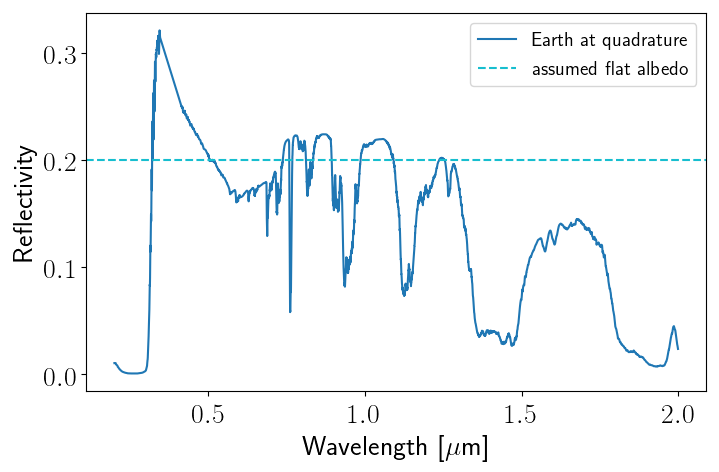

In [7]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

lammin = 0.2
lammax = 2.0
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m], label = "Earth at quadrature")
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Reflectivity")
plt.axhline(Ahr_flat, ls = "--", c = "C9", label = "assumed flat albedo")
plt.legend(fontsize = 14)

In [8]:
# Create generic coronagraph noise object
cn = cg.CoronagraphNoise()

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:290: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:291: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt


/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3236: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]
/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3238: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]


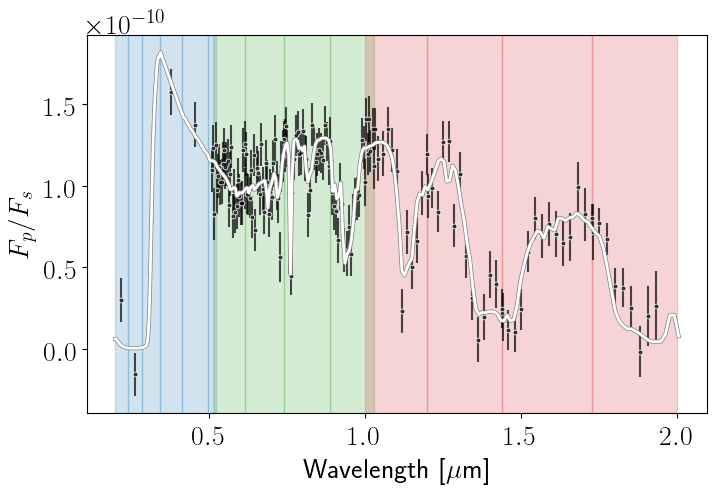

In [9]:
t_tot, tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=True, wantSNR = wantSNR, 
                                                                  Ahr_flat = Ahr_flat, bandwidth = bandwidth, 
                                                                  architecture = architecture)

In [10]:
# Get biased stellar catalog 
biased_sample = spectroscopy.STARS
biased_sample.keys()
NBIAS = len(biased_sample["dist"])

In [11]:
NBIAS

29

## Calculate the exposure times and spectra in each bandpass for each star in biased sample

In [12]:
# Perform calculation for all stars in biased sample
Ndraw = NBIAS

np.random.seed(seed=None)

# Allocate memory for exposure times
t_tots = np.zeros(Ndraw)
tpbpcs = []
pct_obs_iwas = []
lammax_obs_iwas = []
specs = []

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    # Calculate the time to observe the complete spectrum
    t_tots[i], tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=False, 
                                                                          wantSNR = wantSNR, 
                                                                          Ahr_flat = Ahr_flat, 
                                                                          bandwidth = bandwidth, 
                                                                          architecture = architecture) 
    
    
    tpbpcs.append(tpbpc)
    pct_obs_iwas.append(iwa[0])
    specs.append(spectrum)

../scripts/spectroscopy.py:342: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:287: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:287: RuntimeWarning: invalid value encountered in true_divide
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)


In [13]:
# Calculate channel widths
deltas = []
for channel in spectroscopy.CHANNELS:
    l = spectroscopy.default_luvoir(channel=channel)
    deltas.append(l.lammax - l.lammin)
deltas = np.array(deltas)

# Calculate channel fractional completeness
channel_weights = (deltas / np.sum(deltas))

# Calculate completeness for each star in sample
completeness = np.sum(np.array(pct_obs_iwas) * channel_weights, axis = 1)

In [14]:
completeness

array([0.75      , 0.82336957, 0.9673913 , 1.        , 0.79347826,
       0.82336957, 0.64130435, 0.38858696, 0.36684783, 0.48641304,
       0.82336957, 0.59782609, 0.82336957, 0.66304348, 0.62771739,
       0.82336957, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.64130435, 0.79076087, 0.55646135, 0.41032609,
       0.5298913 , 0.49728261, 0.33423913, 0.82336957])

Text(0,0.5,'Total Exposure Time [hrs]')

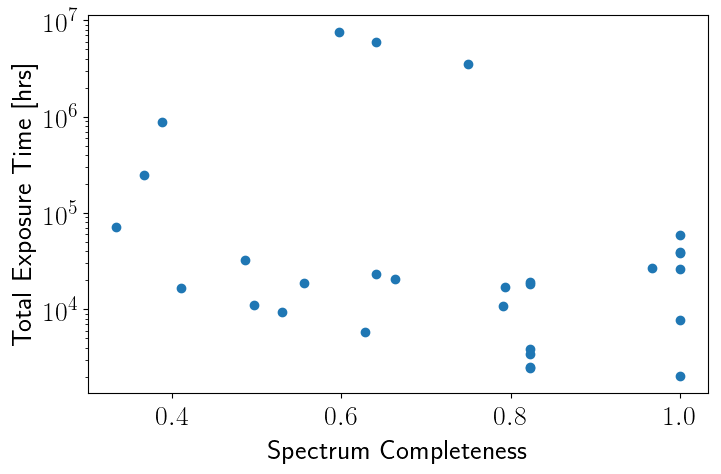

In [15]:
# Plot it!
plt.plot(completeness, t_tots, "o")
plt.yscale("log")
plt.xlabel("Spectrum Completeness")
plt.ylabel("Total Exposure Time [hrs]")

## Make a Lookup Table of Exposure times for each star in sample

In [16]:
tpbpcs_rect = []    # Time per bandpass 
tpcs_rect = []      # Time per channel 

for idrew in range(NBIAS):
    
    tpbpcs_rect.append([])
    tpcs_rect.append([])
    bp_names = []
    bp_chan = []

    for ichan in range(len(spectroscopy.CHANNELS)):
        
        tpcs_rect[idrew].append(0.0)

        for iband in range(len(tpbpcs[0][ichan])):
            
            bp_names.append("%s %i" %(spectroscopy.CHANNELS[ichan], iband+1))
            bp_chan.append(ichan)
            tpbpcs_rect[idrew].append(tpbpcs[idrew][ichan][iband])
            tpcs_rect[idrew][ichan] += tpbpcs[idrew][ichan][iband]
        
tpbpcs_rect = np.array(tpbpcs_rect)
tpcs_rect = np.array(tpcs_rect)
bp_names = np.array(bp_names)
bp_chan = np.array(bp_chan)

# Make infs --> nans
infmask = ~np.isfinite(tpbpcs_rect)
tpbpcs_rect[infmask] = np.nan
infmask = ~np.isfinite(tpcs_rect)
tpcs_rect[infmask] = np.nan

### New completeness calculations

In [17]:
bandpasses = []

# Loop over telescope channels
for j, channel in enumerate(spectroscopy.CHANNELS):

    # Get the channel specific telescope parameters
    luvoir = spectroscopy.default_luvoir(channel=channel)
    cn.telescope = luvoir

    # Calculate the bandpass edges
    edges = spectroscopy.calculate_bandpass_edges(luvoir.lammin, luvoir.lammax, bandwidth = bandwidth)

    # Calculate the number of bandpasses
    Nbands = len(edges) - 1

    # Loop over bandpasses
    for i in range(Nbands):

        # Get the max, min, and middle wavelenths for this bandpass
        lammin = edges[i]
        lammax = edges[i+1]
        
        bandpasses.append([lammin, lammax])
        
bandpasses = np.array(bandpasses)
lmin, lmax = np.min(np.hstack(bandpasses)), np.max(np.hstack(bandpasses))

# Fractional completeness of each bandpass
bp_frac = ((bandpasses[:,1] - bandpasses[:,0]) / (lmax - lmin)) / np.sum((bandpasses[:,1] - bandpasses[:,0]) / (lmax - lmin))

# Completeness by target
tot_completeness = np.sum(np.isfinite(tpbpcs_rect) * bp_frac, axis=1)

# Fraction of stars in biased sample that can completely observe each bandpass
frac_bias_bp = np.sum(np.isfinite(tpbpcs_rect)*1.0, axis=0) / NBIAS

In [69]:
bandpasses

array([[0.2     , 0.24    ],
       [0.24    , 0.288   ],
       [0.288   , 0.3456  ],
       [0.3456  , 0.41472 ],
       [0.41472 , 0.497664],
       [0.497664, 0.525   ],
       [0.515   , 0.618   ],
       [0.618   , 0.7416  ],
       [0.7416  , 0.88992 ],
       [0.88992 , 1.03    ],
       [1.      , 1.2     ],
       [1.2     , 1.44    ],
       [1.44    , 1.728   ],
       [1.728   , 2.      ]])

In [18]:
data = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpbpcs_rect.T, 
                  tot_completeness])
columns = np.hstack(["HIP", "type", "d [pc]", bp_names, "Spec. Completeness"])

isort = np.argsort(tpbpcs_rect[:,6])

table = pd.DataFrame(data[:, isort].T, columns=columns)
table

,HIP,type,d [pc],UV 1,UV 2,UV 3,UV 4,UV 5,UV 6,vis 1,vis 2,vis 3,vis 4,NIR 1,NIR 2,NIR 3,NIR 4,Spec. Completeness
0,91772,K5,3.49174,7556.898771356197,115.30105818688882,9.296658210183065,2.5049567690549948,0.5605885712163582,0.822201684063192,4.6767365134395655,3.5495499015906367,4.637277033189163,2.1818360082351007,1.5467266434331253,1.6171091141824308,2.2127017494763486,6.228504328157806,1.0
1,1475,M1V,3.56201,3532376.7307749074,9994.464256025245,132.84633047360006,12.29768020978859,1.465486499021928,1.6927852571459612,8.857289854502556,4.7736313323657384,4.9454179791011645,1.932092834308905,1.3602737981731545,1.196989987973838,nan,nan,0.6956521739130435
2,96100,K0V,5.76037,2423.980710797476,91.62197608170489,12.987126932965305,4.792172340458742,1.365594116411192,2.3003661340538817,14.938332400249903,13.627435675002104,21.201945641636737,11.231421244308466,11.267417135574332,13.536764391613383,21.149315378570588,70.3765983249351,1.0
3,73184,K4V,5.84044,26504.216236141823,396.57062814207796,27.774011066631495,7.439870780339243,1.728125399690415,2.6653841572462604,16.899234813445045,13.61954248538679,19.502165915587085,9.64956724824994,9.593137737875269,10.719265896011981,15.764490834186391,49.35270524457082,1.0
4,45343,M0V,5.81125,5915582.714465754,22258.415864391332,353.4118700154191,35.35747401314068,4.435635159212948,5.439389535004542,32.33726134118253,18.644832907464224,21.29533006476724,8.808111141904622,8.204053762174036,nan,nan,nan,0.5652173913043478
5,99701,M0V,6.16371,7485186.015181604,28081.718201670028,438.2274668659433,42.809782711940265,5.280153965834874,6.473493326943137,39.05172259620075,22.453940628573456,25.77155938598381,10.673179294704447,10.232570375761826,nan,nan,nan,0.5652173913043478
6,64924,G5V,8.55505,1892.581825218872,116.32848394317399,21.75537756564648,9.658992257357989,3.213235035407303,5.968103312742506,42.960652938090476,44.55317443781207,78.73769526387008,45.20459378858669,58.233087497594674,76.19100033801513,128.5856906269494,466.92532380515,1.0
7,85295,K7V,7.73635,884894.3435647192,6450.916564549358,192.63943669399475,31.15594555932428,5.429907816263146,7.7263779596020985,51.432725650595664,36.255151452505345,48.8906431012333,22.709389072266852,25.31392517703417,nan,nan,nan,0.5652173913043478
8,56452,K0V,9.56114,16700.119031754686,459.96910182028034,49.63856043844717,17.405358300296218,4.9995333295985125,8.783367990719341,64.21279210905584,61.28608368731403,103.44552444275108,56.73346114784659,75.08944767992055,93.03942453541369,nan,nan,0.6956521739130435
9,58345,K4V,10.2218,242755.62217432255,3094.5411752454265,156.95907779201622,36.63596445092609,8.221914524669415,13.197181837200288,96.125739747721,79.78888680759874,123.0677770792955,62.72525447312682,80.28291833743387,nan,nan,nan,0.5652173913043478


# Detect Individual Molecular Bands

## Reproduce Feng et al. (2018) SNR scaling relationship

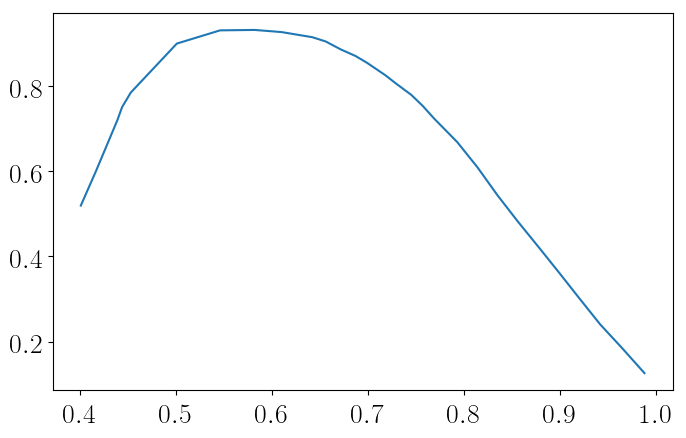

In [19]:
qe_data = np.genfromtxt("../inputs/QE_Feng_2018.txt", skip_header=1)
lam_qe = qe_data[:,0]
qe_lam = qe_data[:,1]

plt.plot(lam_qe, qe_lam)

(0.55, 0.9993125)
(0.75, 0.8120384615384615)
(0.77, 0.7481923076923077)
(0.8120384615384615, 0.7481923076923077, 0.7801153846153845)


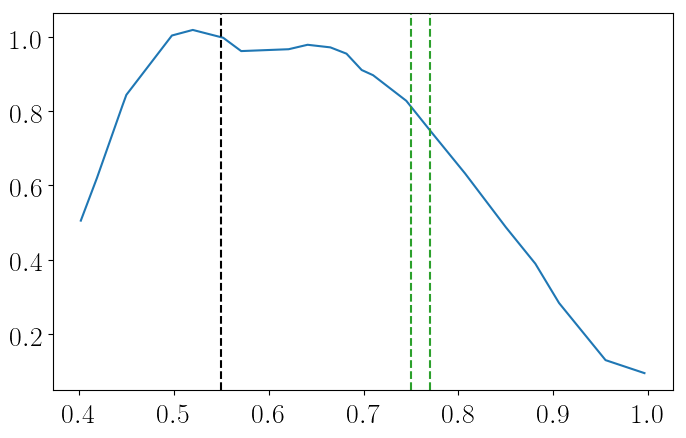

In [20]:
snr_data = np.genfromtxt("../inputs/SNR_Feng_18.txt", skip_header=1)
lam_snr_feng = snr_data[:,0]
snr_lam_feng = snr_data[:,1]

plt.plot(lam_snr_feng, snr_lam_feng)

x = 0.550
y = np.interp(x, lam_snr_feng, snr_lam_feng)
plt.axvline(x, ls="--", c = "k")
print(x, y)

x = 0.75
y1 = np.interp(x, lam_snr_feng, snr_lam_feng)
plt.axvline(x, ls="--", c = "C2")
print(x,y1)

x = 0.77
y2 = np.interp(x, lam_snr_feng, snr_lam_feng)
plt.axvline(x, ls="--", c = "C2")
print(x,y2)

print(y1, y2, (y1 + y2) / 2.)

In [21]:
luvoir_feng = spectroscopy.default_luvoir()

luvoir_feng.lammin = 0.4
luvoir_feng.lammax = 1.0

luvoir_feng.qe = 0.01
luvoir_feng.qe_lam = (lam_qe, qe_lam)
luvoir_feng.Tput_lam = None
luvoir_feng.throughput = 0.065

cn.telescope = luvoir_feng

cn.star.Rs = 1.0
cn.star.Teff = 5780.
cn.planet.distance = 5.0
cn.planet.a = 1.0

# Run count rates (necessary to generate new wavelength grid)
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

15.070493214233082


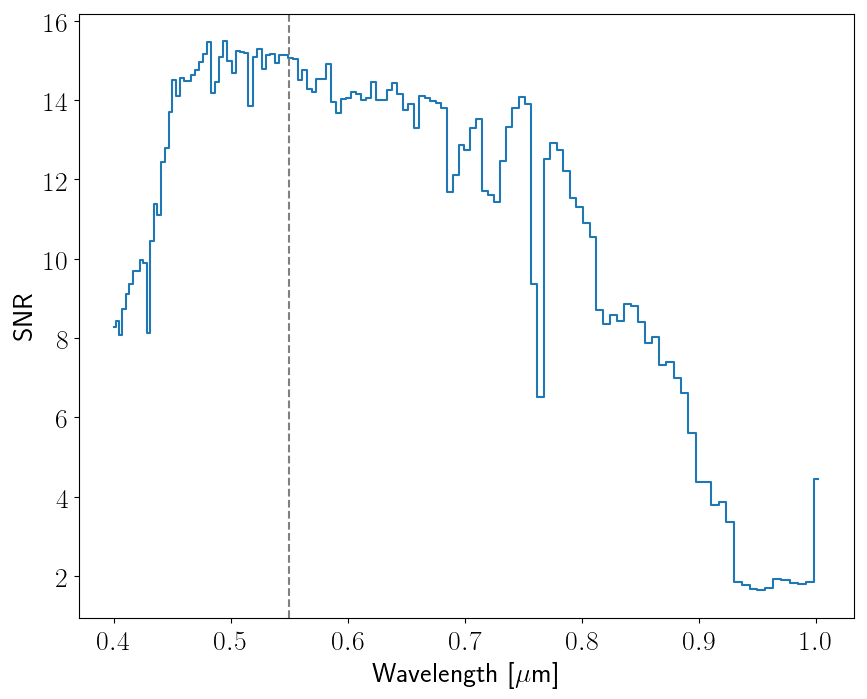

In [22]:
i550 = np.argmin(np.fabs(cn.lam - 0.550))

snr_feng = cn.SNRt #/ cn.SNRt[i550]

fig, ax = plt.subplots(figsize = (10,8))
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("SNR")
ax.plot(cn.lam, snr_feng, ls = "steps-mid")
ax.axvline(0.550, c = "gray", ls = "dashed")
print(cn.SNRt[i550])

SNR_O2A = SNR_550nm * 0.357


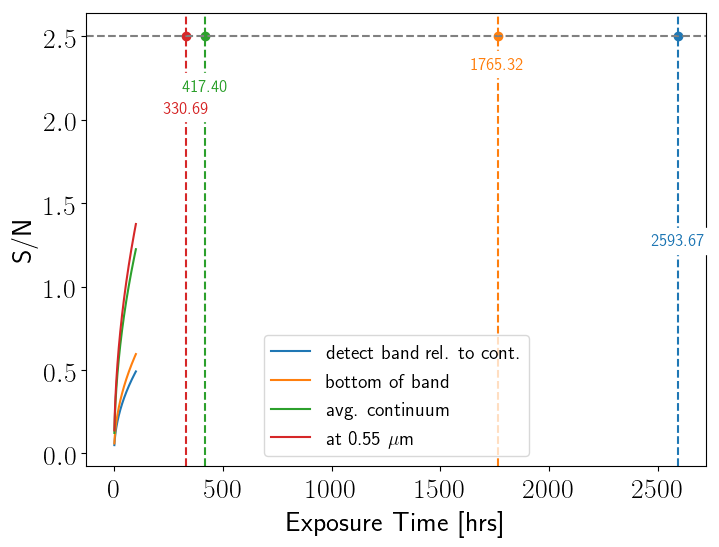

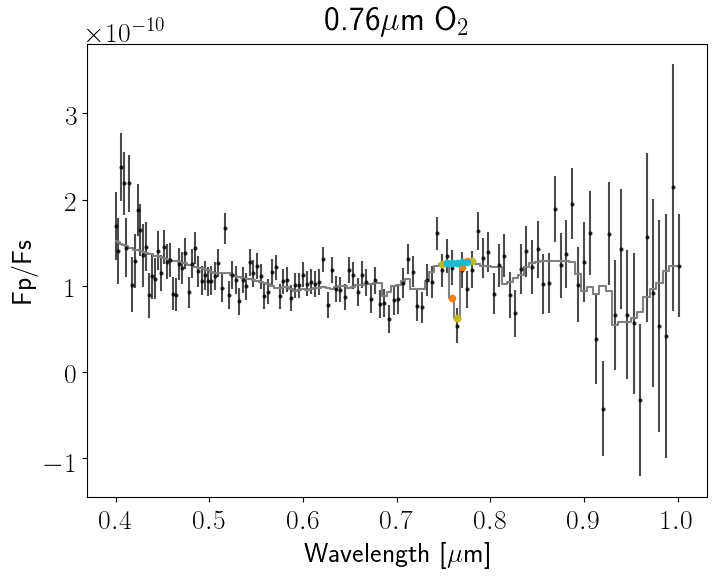

In [23]:
etimes = spectroscopy.determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", 
                                 plot_snr_curves=True, plot_spectrum=True, wantSNR=2.5)

rat_snr_o2a = np.sqrt(etimes[3] / etimes[0])

print("SNR_O2A = SNR_550nm * %.3f" %(rat_snr_o2a))

### Test additional molecular bands

SNR_H2O = SNR_550nm * 0.165
SNR_H2O = SNR_550nm * 0.215
SNR_H2O = SNR_550nm * 0.188
SNR_H2O = SNR_550nm * 0.391


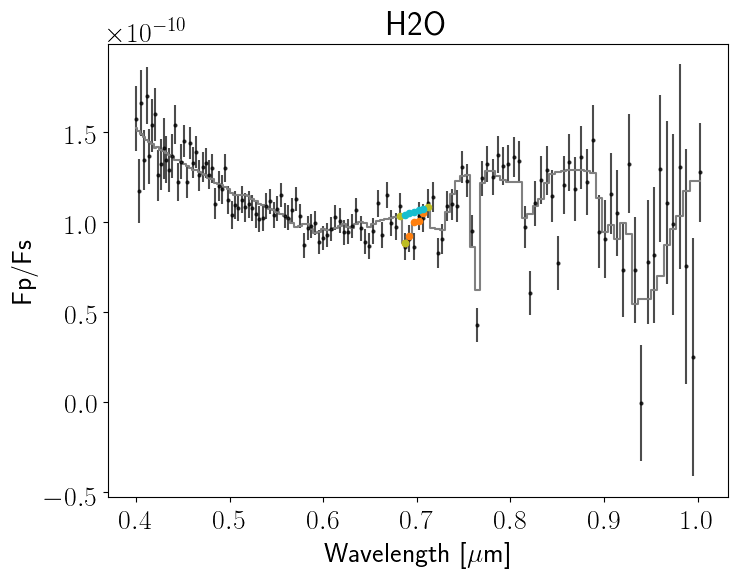

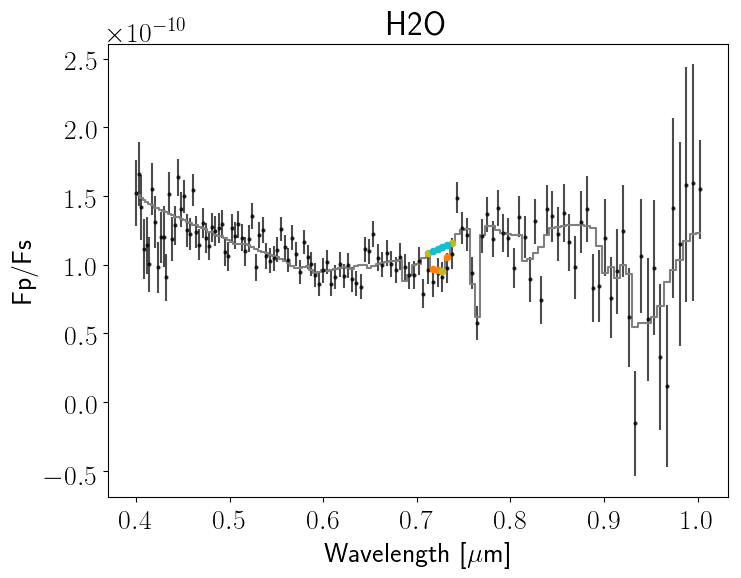

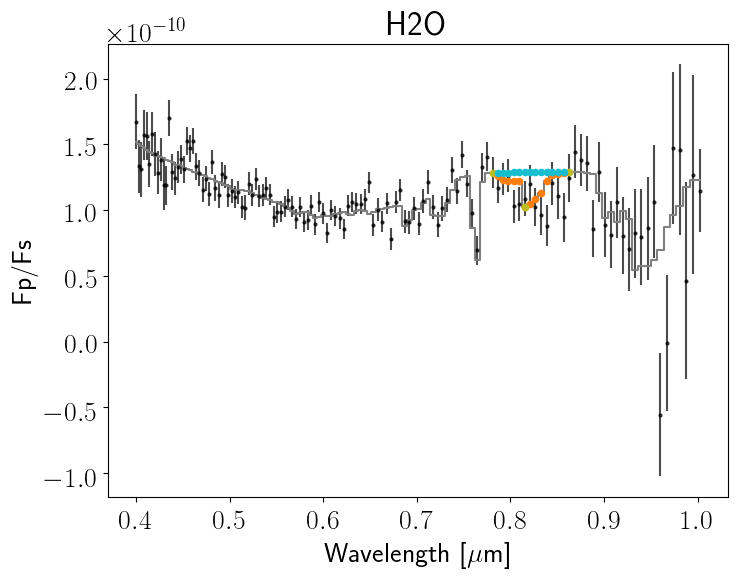

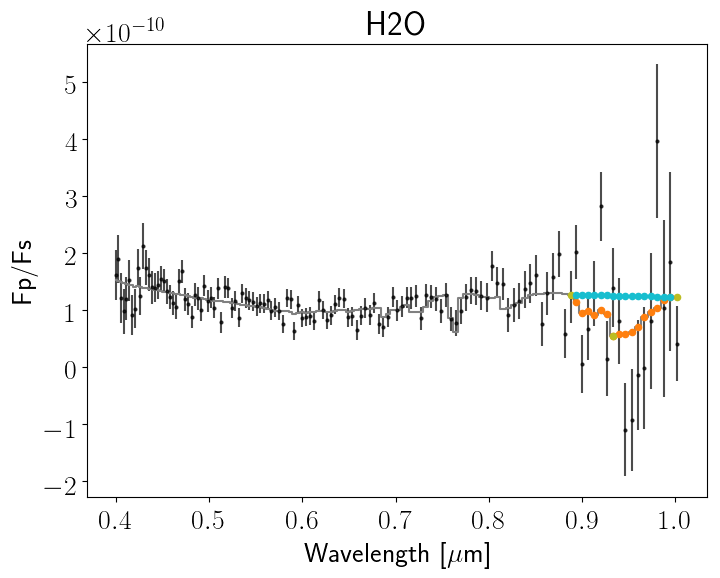

In [24]:
etimes = spectroscopy.determine_exposure_time(cn, [0.68, 0.71], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.71, 0.74], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.78, 0.86], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.89, 1.0], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))

SNR_O3 = SNR_550nm * 0.076


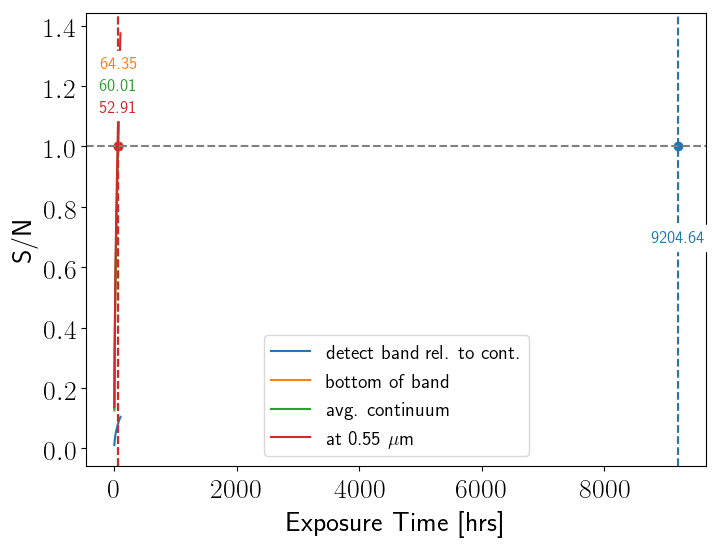

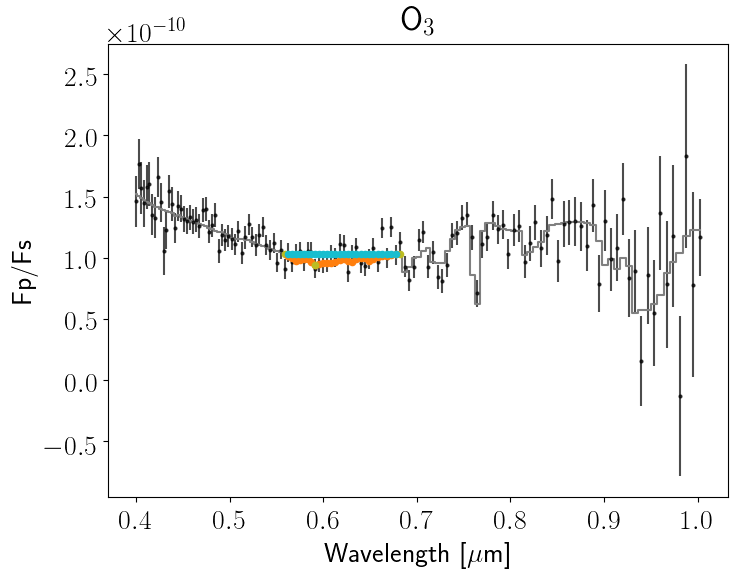

In [25]:
# vis
#cn.telescope = spectroscopy.default_luvoir(channel="vis", architecture="A")

# Run count rates (necessary to generate new wavelength grid)
#cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

# O3
etimes_O3 = spectroscopy.determine_exposure_time(cn, [0.56, 0.68], title = "O$_3$", 
                             plot_snr_curves=True, plot_spectrum=True, wantSNR=1.)

rat_snr_o3 = np.sqrt(etimes_O3[3] / etimes_O3[0])

print("SNR_O3 = SNR_550nm * %.3f" %(rat_snr_o3))

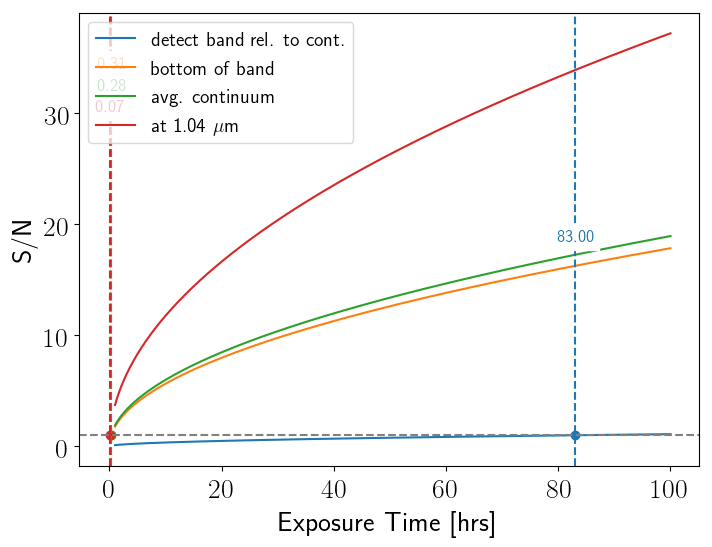

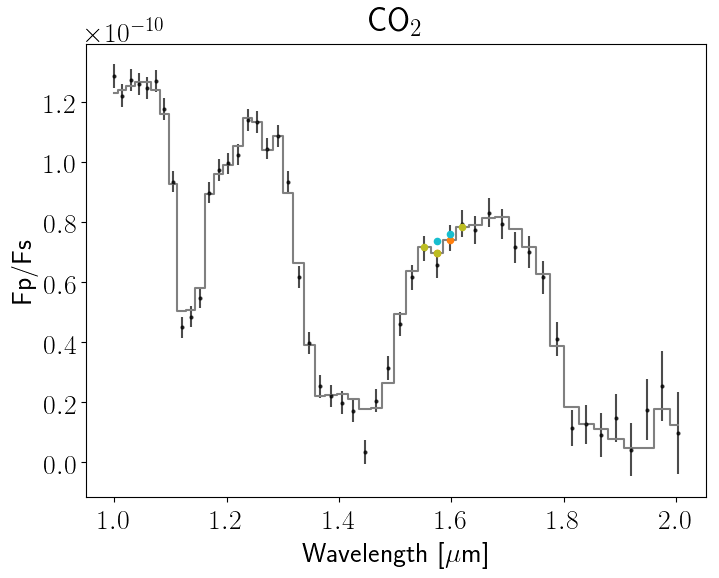

In [26]:
# NIR
cn.telescope = spectroscopy.default_luvoir(channel="NIR", architecture="A")
cn.telescope.resolution = 70.

# Run count rates (necessary to generate new wavelength grid)
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

# CO2
etimes_CO2 = spectroscopy.determine_exposure_time(cn, [1.55, 1.63], title = "CO$_2$", 
                             plot_snr_curves=True, plot_spectrum=True, wantSNR=1.,
                             ref_lam = 1.05)

## Calculate time to detect molecular bands for each star in sample

In [27]:
molecule_list = ["O2", "O3", "CO2", "H2O"]

molecule_bands = {
    "O2"   : ( [0.75, 0.78], ), 
    "O3"   : ( [0.56, 0.68], ), 
    "CO2"  : ( [1.55, 1.63], ),
    "H2O"  : ( [0.68, 0.71], [0.71, 0.74], [0.78, 0.86], [0.89, 1.0])
}

def get_mband_channel(bandlims, architecture="A"):
    """
    Get the LUVOIR channel name for a given bandwidth, ``bandlims``
    """
    
    for chan in spectroscopy.CHANNELS:
        
        ts = spectroscopy.default_luvoir(channel=chan, architecture=architecture)
        
        if (bandlims[0] >= ts.lammin) and (bandlims[1] <= ts.lammax):
            
            return chan
        
    return None

def total_molec_bands(mol_dict):
    """
    """
    k = 0
    # Loop over each molecular band
    for molec in mol_dict.keys():
        for band in mol_dict[molec]: 
            k += 1
    return k

def get_mband_names():
    names = []
    # Loop over each molecular band
    for molec in molecule_list:
        for i, band in enumerate(molecule_bands[molec]): 
            names.append(molec + "_%i" %(i+1))
    return names

In [28]:
print(get_mband_channel(molecule_bands["O2"][0]))
print(total_molec_bands(molecule_bands))
print(get_mband_names())

vis
7
['O2_1', 'O3_1', 'CO2_1', 'H2O_1', 'H2O_2', 'H2O_3', 'H2O_4']


In [29]:
wantSNR_bands = 10.0

# Perform calculation for all stars in biased sample
Ndraw = len(biased_sample["dist"])
Nbands = total_molec_bands(molecule_bands) 

np.random.seed(seed=None)

# Allocate memory for exposure times
tpmbs = np.zeros((Ndraw, Nbands
                  , 4))

# Loop over stars in this sample
for i in range(Ndraw):
    
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    k = 0
    # Loop over each molecular band
    for molec in molecule_list:
        for band in molecule_bands[molec]: 
        
            # Get the right LUVOIR channel for this band
            chan = get_mband_channel(band, architecture=architecture)
    
            # Set telescope model
            cn.telescope = spectroscopy.default_luvoir(channel=chan, architecture=architecture)
            
            # Run count rates (necessary to generate new wavelength grid)
            cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
    
            # Get exposure times
            etimes = spectroscopy.determine_exposure_time(cn, band, title = molec, wantSNR=wantSNR_bands,
                                         plot_snr_curves=False, plot_spectrum=False)
            
            # Save band detection
            tpmbs[i,k,:] = np.array(etimes)
            
            k += 1
            
# etime_band, etime_bot, etime_cont, etime_fid

In [30]:
data2 = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpmbs[:,0,0], 
                  tpmbs[:,1,0], 
                  tpmbs[:,2,0], 
                  tpmbs[:,3,0], 
                  tpmbs[:,4,0], 
                  tpmbs[:,5,0], 
                  tpmbs[:,6,0]])
columns = np.hstack(["HIP", "type", "d [pc]", "O2 0.76", "O3 0.6", "CO2 1.6", "H2O 0.7", "H2O 0.73", "H2O 0.83", "H2O 0.94"])

isort = np.argsort(tpmbs[:,0,0])

table2 = pd.DataFrame(data2[:, isort].T, columns=columns)
table2.head(n = 10)

,HIP,type,d [pc],O2 0.76,O3 0.6,CO2 1.6,H2O 0.7,H2O 0.73,H2O 0.83,H2O 0.94
0,1475,M1V,3.56201,16.65989324876703,472.00628937791424,nan,102.4927013933501,73.89927083917733,9.337016573664446,2.109447394764315
1,91772,K5,3.49174,21.88602970195896,626.4377854530817,3905.461000352332,137.69647427155616,98.20348395592231,11.750797334152034,2.6643326289686295
2,45343,M0V,5.81125,80.13148997196635,1924.275244618601,nan,456.3506887846394,337.3559317231729,45.18512303174735,11.316934179454725
3,99701,M0V,6.16371,97.19962483332098,2291.4715741472983,nan,548.6571780767789,406.79874131770555,54.89895140611639,13.879383397323911
4,73184,K4V,5.84044,101.80245292002584,2593.2975423898183,27576.449088077916,603.9528211306848,438.73080443927415,55.23710391228889,13.394526675870802
5,96100,K0V,5.76037,114.73886459325098,3149.4373850966444,25679.439353705508,708.450424608635,505.6501293935592,60.36008950427911,14.18920231638542
6,85295,K7V,7.73635,229.61897080726914,5202.495683282628,nan,1280.289713566634,952.0133714306834,128.31954581711938,32.85969466895478
7,64924,G5V,8.55505,444.29835552446895,11911.094739062388,117107.8399928194,2704.613198028894,1933.6468947741523,232.38602271110432,55.30312196951018
8,56452,K0V,9.56114,580.4593872628607,14055.548965778156,nan,3362.9455238833134,2454.856778631627,312.4762706030762,77.30952565699002
9,58345,K4V,10.2218,670.330712194737,14889.517671431426,nan,3720.049429128341,2765.532504719902,370.3380337466482,95.25254186610465


It's always more expensive to detect H2O at 0.8 um than 0.94


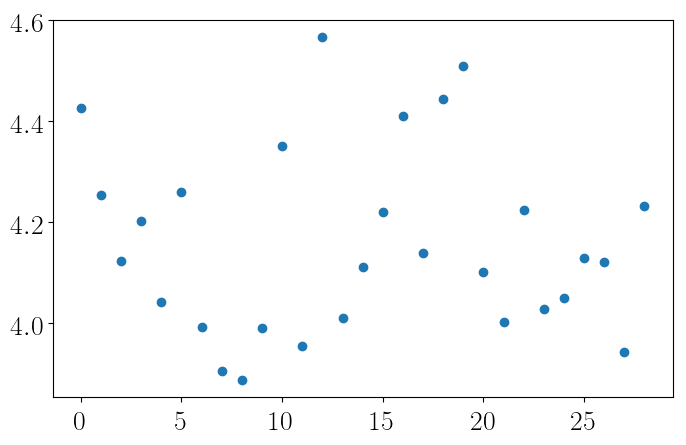

In [31]:
plt.plot(tpmbs[:,5,0] /  tpmbs[:,6,0], "o")
print("It's always more expensive to detect H2O at 0.8 um than 0.94")

In [32]:
print("------------------------------------")
for i in range(tpmbs.shape[1]):
    print(get_mband_names()[i])
    print("SNR_band = %.2f * SNR_continuum" %(np.nanmedian(np.sqrt(tpmbs[:,i,2] / tpmbs[:,i,0]))))
    #print("SNR_band = %.2f * SNR_fiducial" %(np.nanmedian(np.sqrt(tpmbs[:,i,3] / tpmbs[:,i,0]))))

------------------------------------
O2_1
SNR_band = 0.46 * SNR_continuum
O3_1
SNR_band = 0.08 * SNR_continuum
CO2_1
SNR_band = 0.06 * SNR_continuum
H2O_1
SNR_band = 0.18 * SNR_continuum
H2O_2
SNR_band = 0.22 * SNR_continuum
H2O_3
SNR_band = 0.65 * SNR_continuum
H2O_4
SNR_band = 1.18 * SNR_continuum


In [33]:
print("------------------------------------")
for i in range(tpmbs.shape[1]):
    print(get_mband_names()[i])
    #print("SNR_band = %.2f * SNR_continuum" %(np.nanmedian(np.sqrt(tpmbs[:,i,2] / tpmbs[:,i,0]))))
    print("SNR_550 = %.2f * SNR_fiducial" %(np.nanmedian(np.sqrt(tpmbs[:,i,3] / tpmbs[:,i,2]))))

------------------------------------
O2_1
SNR_550 = 0.80 * SNR_fiducial
O3_1
SNR_550 = 0.91 * SNR_fiducial
CO2_1
SNR_550 = 0.24 * SNR_fiducial
H2O_1
SNR_550 = 0.84 * SNR_fiducial
H2O_2
SNR_550 = 0.82 * SNR_fiducial
H2O_3
SNR_550 = 0.77 * SNR_fiducial
H2O_4
SNR_550 = 0.86 * SNR_fiducial


In [34]:
print("Kat equivalent SNR (R=140) for O2-A band (calculated via intermediate band detection):")
wantSNR * np.nanmedian(np.sqrt(tpmbs[:,0,2] / tpmbs[:,0,0])) / rat_snr_o2a

Kat equivalent SNR (R=140) for O2-A band (calculated via intermediate band detection):


10.848392341626283

In [35]:
print("Kat equivalent SNR (R=140) for O2-A band (calculated via continuum scaling):")
wantSNR / np.nanmedian(np.sqrt(tpmbs[:,0,3] / tpmbs[:,0,2]))

Kat equivalent SNR (R=140) for O2-A band (calculated via continuum scaling):


10.62993057788033

In [36]:
10.**(-.68)

0.20892961308540392

In [37]:
#SNR = 10 O2
print(10.**(-1.06), 10.**(-1.06 + 0.76), 10.**(-1.06 + -1.43))
print((10.**(-1.06 + 0.76) - 10.**(-1.06 + -1.43)) / 10.**(-.68))

(0.08709635899560805, 0.5011872336272722, 0.003235936569296281)
2.38334475283


In [38]:
(10.**(-1.06 + 0.76) - 10.**(-1.06 + -1.43)) / 10.**(-.68)

2.3833447528303657

In [39]:
#SNR = 15 O2
print(10.**(-0.76), 10.**(-0.76 + 0.51), 10.**(-0.76 + -0.79))
print((10.**(-0.76 + 0.51) - 10.**(-0.76 + -0.79)) / 10.**(-.68))

(0.17378008287493754, 0.5623413251903491, 0.028183829312644536)
2.55663851567


In [40]:
print("Kat equivalent SNR (R=140) for O3 band (calculated via intermediate band detection):")
wantSNR * np.nanmedian(np.sqrt(tpmbs[:,0,2] / tpmbs[:,0,0])) / rat_snr_o2a

Kat equivalent SNR (R=140) for O3 band (calculated via intermediate band detection):


10.848392341626283

In [41]:
print("Kat equivalent SNR (R=140) for O3 band (calculated via continuum scaling):")
wantSNR / np.nanmedian(np.sqrt(tpmbs[:,1,3] / tpmbs[:,1,2]))

Kat equivalent SNR (R=140) for O3 band (calculated via continuum scaling):


9.360679682084319

In [42]:
cn.wantsnr

10.0

In [43]:
print("Indices to use for removing bandpasses:")
print("---------------------------------------")
for i in range(len(bp_names)):
    print("%s: %i" %(bp_names[i], i))
print("---------------------------------------")

Indices to use for removing bandpasses:
---------------------------------------
UV 1: 0
UV 2: 1
UV 3: 2
UV 4: 3
UV 5: 4
UV 6: 5
vis 1: 6
vis 2: 7
vis 3: 8
vis 4: 9
NIR 1: 10
NIR 2: 11
NIR 3: 12
NIR 4: 13
---------------------------------------


In [83]:
def run_hec_drm(Ndraw = 5, wantexp_days = 365., verbose = True, iremove = [], wantSNR_grid = None):
    """
    Run the LUVOIR Habitable Exoplanet Characterization (HEC) Design Reference Mission (DRM). 
    
    Parameters
    ----------
    Ndraw : int
        Number of stars drawn out of the total biased sample of habitable Earth-like candidates 
    wantexp_days : float
        Number of days willing to spend on science time for this program
    wantSNR_grid : list or numpy.array
        Desired SNR in each band; calculated via scaling from original ``wantSNR_grid`` 
        (must satisfy: ``len(wantSNR_grid) == len(bp_chan)``)
    iremove : list
        Indices of bandpasses to remove
    verbose : bool
        Use print statements? Good for a single example
        
    Returns
    -------
    """
    
    # Construct mask for bands we're keeping
    val = []
    for i in range(len(bp_names)):
        if i in iremove:
            val.append(False)
        else:
            val.append(True)
    val = np.array(val)

    # Randomly draw stellar sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    # Scale SNRs if need be
    if wantSNR_grid is not None:
        SNRfactor = (wantSNR_grid / wantSNR)**2
    else:
        SNRfactor = np.ones(tpbpcs_rect.shape[1])
    
    # Get exptimes for each star drawn
    tpbpcs_draws = SNRfactor*tpbpcs_rect[idraw, :]

    t_sci = np.zeros(Ndraw) # was t_tot
    c_tot = np.zeros(Ndraw)
    t_ovr = np.zeros(Ndraw)
    
    # Loop over targets 
    for i in range(Ndraw): 
        
        # Science exposure times in each channel
        t_uv = np.nansum(tpbpcs_draws[i, val & (bp_chan == 0)])
        t_vis = np.nansum(tpbpcs_draws[i, val & (bp_chan == 1)])
        t_nir = np.nansum(tpbpcs_draws[i, val & (bp_chan == 2)])
        
        # Total exposure time
        t_sci[i] = spectroscopy.apply_two_channels(np.array([t_uv, t_vis, t_nir]))
        
        # OVERHEADS
        ## 1 hour for slew + dynamic settle + thermal settle
        slew_settle_time = 1.0
        ## 0.6 for A (1.25 for B) hours for digging initial dark hole
        if architecture == "A":
            initial_dark_hole_tax = 0.6
        elif architecture == "B":
            initial_dark_hole_tax = 1.25
        else:
            initial_dark_hole_tax = np.nan
        ## GUESS: apply initial dark hole tax to each bandpass (flat tax * number of bandpasses used)
        dark_hole_time = initial_dark_hole_tax * np.sum(np.isfinite(tpbpcs_draws[i, val]))
        ## 10% science time tax per iteration of wavefront control
        Nwfc = 1.0   # Assuming one iteration
        fwfc = 0.1 * Nwfc
        ## GUESS: apply WFC science tax to total science time after accounting for simultaneous observations in two channels
        wfc_time = fwfc * t_sci[i]
        ## Sum up the overheads
        t_ovr[i] = slew_settle_time + dark_hole_time + wfc_time
        
        # Completeness = initial completeness - fraction contributed from removed bands
        mask = np.isfinite(tpbpcs_draws[i, :]) & ~val
        c_tot[i] = tot_completeness[idraw[i]] - np.sum(bp_frac[mask])
        
        # Print?
        if verbose:
            print("HIP%s - %s - %.2fpc" %(biased_sample["hip"][idraw[i]], biased_sample["stype"][idraw[i]], biased_sample["dist"][idraw[i]]))
            print("    - %.1f%% Complete Spectrum : %.2f days" %(c_tot[i] * 100., t_sci[i] / 24.))
            print("    - UV Spectrum : %.2f days" %(t_uv / 24.))
            print("    - Optical Spectrum : %.2f days" %(t_vis / 24.))
            print("    - NIR Spectrum : %.2f days" %(t_nir / 24.))
            print("    - Overhead %.2f days" %(t_ovr[i] / 24.))
            #print("    - O2 0.76 um : %.2f days" %(tpmbs[idraw[i],0,0] / 24.))
            #print("    - O3 0.6 um : %.2f days" %(tpmbs[idraw[i],1,0] / 24.))
     
    # Sum science time and overheads 
    t_tot = t_sci + t_ovr
    
    # Calculate total science exposure time for all Ndraw targets
    t_sci_sum = np.sum(t_sci)
    
    # Calculate total overhead time for all Ndraw targets
    t_ovr_sum = np.sum(t_ovr)
    
    # Calculate total science + overhead time for all Ndraw targets
    t_tot_sum = np.sum(t_tot)
    
    # Prioritize targets for fixed desired exposure time
    isort = np.argsort(t_tot)
    t_tot_cumsum = np.cumsum(t_tot[isort])
    viable = (t_tot_cumsum / 24.) < wantexp_days
    count_in_texp = np.sum(viable)
    if count_in_texp > 0:
        texp_for_count = t_tot_cumsum[viable][-1] / 24 
    else:
        texp_for_count = 0
    
    if verbose:
        print("---------------------FINAL TALLY---------------------")
        print("%.2f yrs for %i target's complete spectra with overheads (SNR=%i)" %(t_tot_sum / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's complete spectra just science time (SNR=%i)" %(t_sci_sum / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's complete spectra just overheads (SNR=%i)" %(t_ovr_sum / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's UV spectra (SNR=%i)" %(np.nansum(tpbpcs_draws[:, val & (bp_chan == 0)]) / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's optical spectra (SNR=%i)" %(np.nansum(tpbpcs_draws[:, val & (bp_chan == 1)]) / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's NIR spectra (SNR=%i)" %(np.nansum(tpbpcs_draws[:, val & (bp_chan == 2)]) / (24. * 356.), Ndraw, wantSNR))
        #print("%.2f yrs for %i target's O2 at 0.76 um (SNR=%i)" %(np.nansum(tpmbs[idraw,0,0]) / (24. * 356.), Ndraw, wantSNR_bands))
        #print("%.2f yrs for %i target's O3 at 0.6 um (SNR=%i)" %(np.nansum(tpmbs[idraw,1,0]) / (24. * 356.), Ndraw, wantSNR_bands))
        print("%i spectra in %i days (%i desired for program)" %(count_in_texp, texp_for_count, wantexp_days))        

    return t_tot[isort], count_in_texp, c_tot[isort], tpbpcs_draws[isort, :], t_sci[isort], t_ovr[isort]

### Run a single example

In [84]:
np.random.seed(seed = 3)
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = 5, iremove = [], wantexp_days=wantexp)

HIP36366 - F0V... - 18.05pc
    - 100.0% Complete Spectrum : 1640.79 days
    - UV Spectrum : 112.28 days
    - Optical Spectrum : 229.00 days
    - NIR Spectrum : 1640.79 days
    - Overhead 164.85 days
HIP98767 - G6IV+... - 16.03pc
    - 100.0% Complete Spectrum : 1592.66 days
    - UV Spectrum : 1592.66 days
    - Optical Spectrum : 139.50 days
    - NIR Spectrum : 362.26 days
    - Overhead 160.04 days
HIP59199 - F0IV/V - 14.94pc
    - 100.0% Complete Spectrum : 809.07 days
    - UV Spectrum : 96.36 days
    - Optical Spectrum : 168.17 days
    - NIR Spectrum : 809.07 days
    - Overhead 81.68 days
HIP110649 - F9V - 20.56pc
    - 56.5% Complete Spectrum : 461.27 days
    - UV Spectrum : 461.27 days
    - Optical Spectrum : 203.44 days
    - NIR Spectrum : 92.37 days
    - Overhead 46.74 days
HIP77257 - G0Vvar - 12.12pc
    - 100.0% Complete Spectrum : 162.84 days
    - UV Spectrum : 94.92 days
    - Optical Spectrum : 32.71 days
    - NIR Spectrum : 162.84 days
    - Overhead 17.06

### Test 1) No bandpasses removed

HIP36366 - F0V... - 18.05pc
    - 100.0% Complete Spectrum : 1640.79 days
    - UV Spectrum : 112.28 days
    - Optical Spectrum : 229.00 days
    - NIR Spectrum : 1640.79 days
    - Overhead 164.85 days
HIP98767 - G6IV+... - 16.03pc
    - 100.0% Complete Spectrum : 1592.66 days
    - UV Spectrum : 1592.66 days
    - Optical Spectrum : 139.50 days
    - NIR Spectrum : 362.26 days
    - Overhead 160.04 days
HIP59199 - F0IV/V - 14.94pc
    - 100.0% Complete Spectrum : 809.07 days
    - UV Spectrum : 96.36 days
    - Optical Spectrum : 168.17 days
    - NIR Spectrum : 809.07 days
    - Overhead 81.68 days
---------------------FINAL TALLY---------------------
12.50 yrs for 3 target's complete spectra with overheads (SNR=8)
11.36 yrs for 3 target's complete spectra just science time (SNR=8)
1.14 yrs for 3 target's complete spectra just overheads (SNR=8)
5.06 yrs for 3 target's UV spectra (SNR=8)
1.51 yrs for 3 target's optical spectra (SNR=8)
7.90 yrs for 3 target's NIR spectra (SNR=8)
0 sp

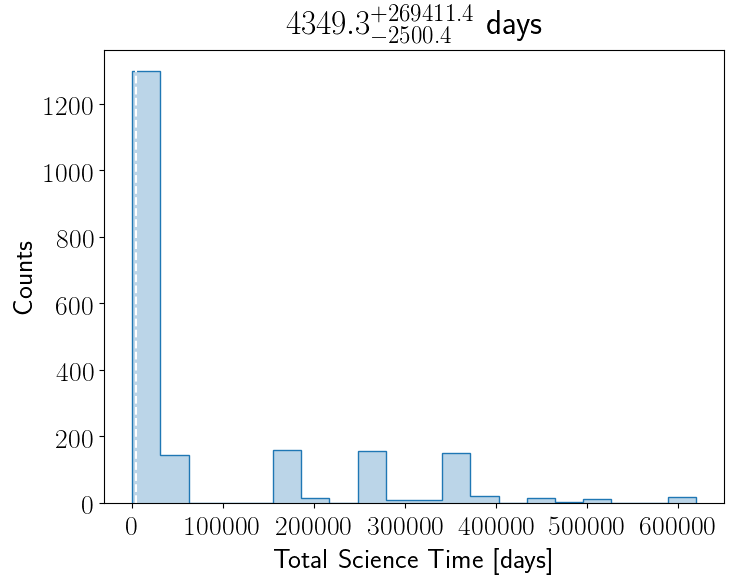

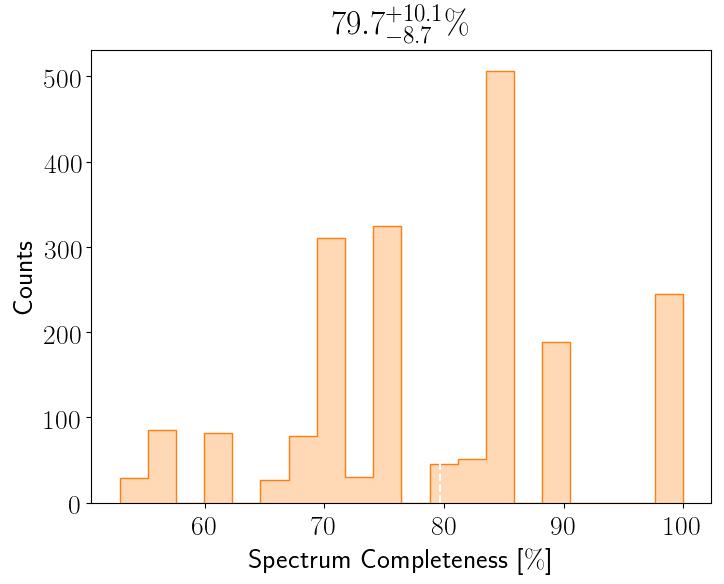

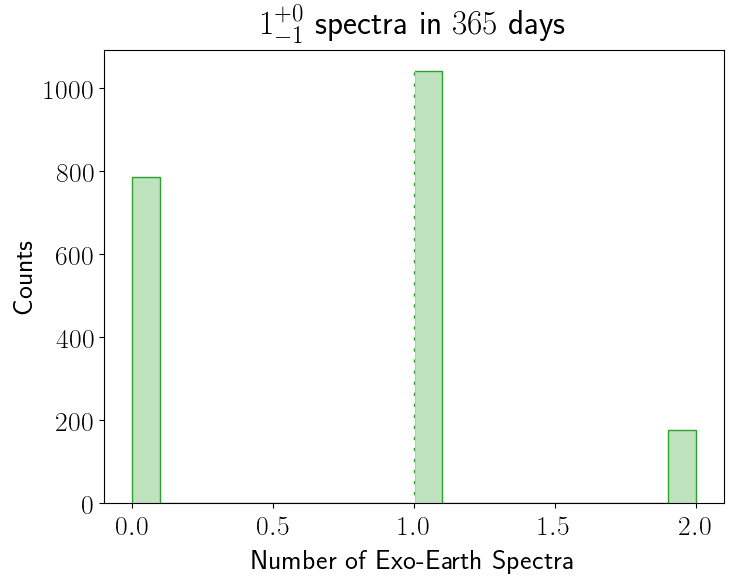

In [85]:
# No Bands Removed
iremove = []
Xdraw = 2000

# Set RNG seed for reproducible randomness
np.random.seed(seed = 3)

# Run DRM for a single representative output with print statements
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, iremove = iremove, wantexp_days=wantexp)

# Set RNG seed for random sampling
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
c_totx = np.zeros(Xdraw)
countx = np.zeros(Xdraw)
tpbpcx = np.zeros((Xdraw, Ndraw_fid, len(bp_names)))
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw=Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx[x] = np.sum(t_tot_sort)
    c_totx[x] = np.mean(c_tot_sort)
    countx[x] = count_in_texp
    tpbpcx[x,:,:] = tpbpcs_draws
    
# Plot exposure time hist
color = "C0"
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = color);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot completeness hist
color = "C1"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_totx * 100.)
result = "$%.1f^{+%.1f}_{-%.1f}\%%$" %(q_50, q_p, q_m)
ax.set_xlabel("Spectrum Completeness [$\%$]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(c_totx * 100., bins = 20, alpha = .3, color = color);
ax.hist(c_totx * 100., bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot time-limited program count hist
color = "C2"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(countx)
result = "$%i^{+%i}_{-%i}$ spectra in $%i$ days" %(q_50, q_p, q_m, wantexp)
ax.set_xlabel("Number of Exo-Earth Spectra")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(countx, bins = 20, alpha = .3, color = color);
ax.hist(countx, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

### Test 2.1) Two bandpasses removed: -2 UV

HIP36366 - F0V... - 18.05pc
    - 95.2% Complete Spectrum : 1640.79 days
    - UV Spectrum : 17.39 days
    - Optical Spectrum : 229.00 days
    - NIR Spectrum : 1640.79 days
    - Overhead 164.75 days
HIP98767 - G6IV+... - 16.03pc
    - 95.2% Complete Spectrum : 362.26 days
    - UV Spectrum : 33.02 days
    - Optical Spectrum : 139.50 days
    - NIR Spectrum : 362.26 days
    - Overhead 36.89 days
HIP59199 - F0IV/V - 14.94pc
    - 95.2% Complete Spectrum : 809.07 days
    - UV Spectrum : 15.64 days
    - Optical Spectrum : 168.17 days
    - NIR Spectrum : 809.07 days
    - Overhead 81.57 days
---------------------FINAL TALLY---------------------
8.69 yrs for 3 target's complete spectra with overheads (SNR=8)
7.90 yrs for 3 target's complete spectra just science time (SNR=8)
0.80 yrs for 3 target's complete spectra just overheads (SNR=8)
0.19 yrs for 3 target's UV spectra (SNR=8)
1.51 yrs for 3 target's optical spectra (SNR=8)
7.90 yrs for 3 target's NIR spectra (SNR=8)
0 spectra in 0

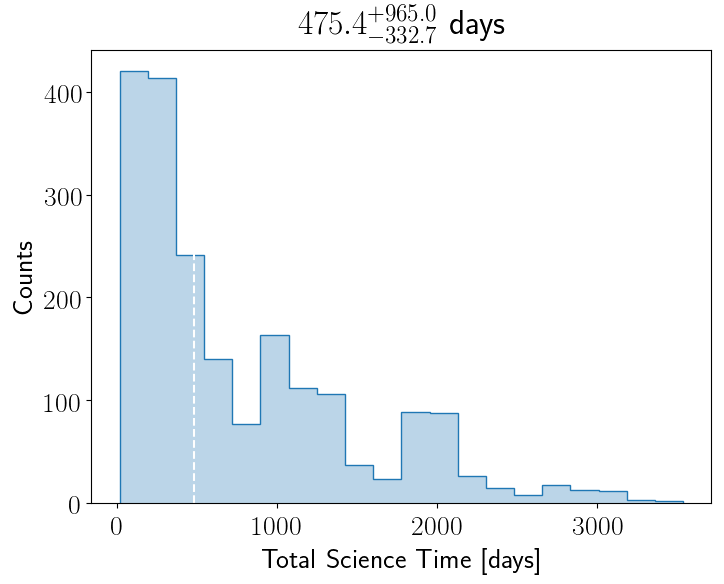

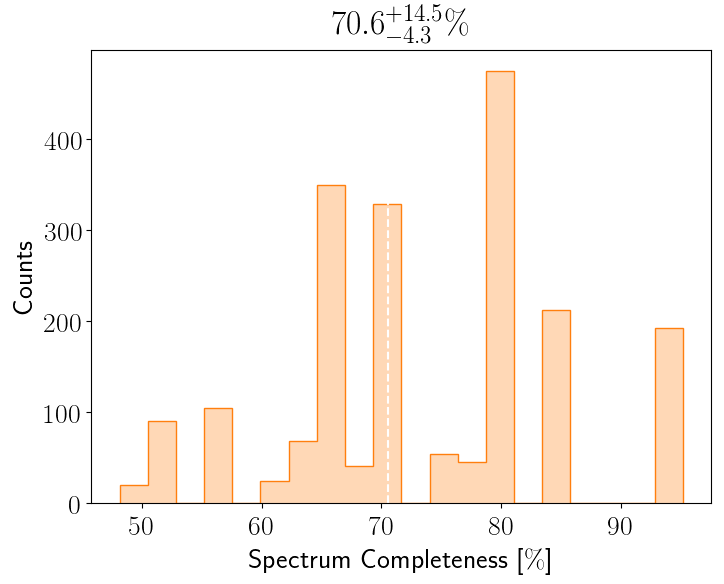

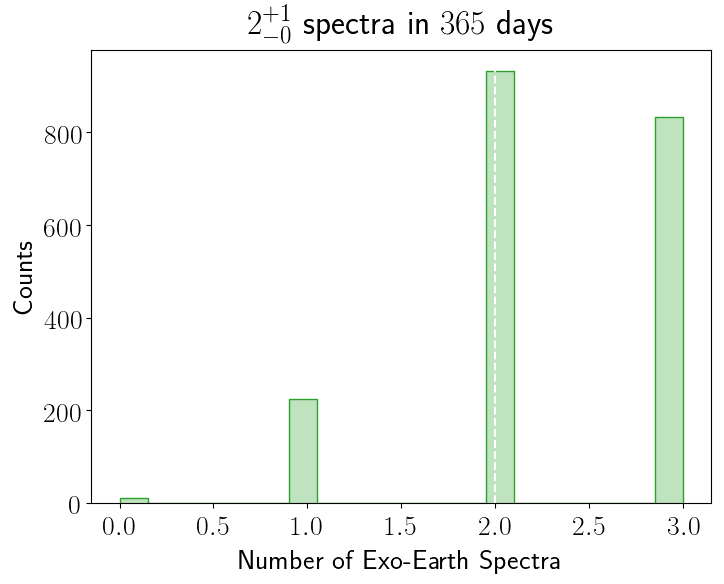

In [47]:
# 2 bands removed
iremove = [0,1]
Xdraw = 2000

# Set RNG seed for reproducible randomness
np.random.seed(seed = 3)

# Run DRM for a single representative output with print statements
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, iremove = iremove, wantexp_days=wantexp)

# Set RNG seed for random sampling
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
c_totx = np.zeros(Xdraw)
countx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx[x] = np.sum(t_tot_sort)
    c_totx[x] = np.mean(c_tot_sort)
    countx[x] = count_in_texp
    
# Plot exposure time hist
color = "C0"
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = color);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot completeness hist
color = "C1"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_totx * 100.)
result = "$%.1f^{+%.1f}_{-%.1f}\%%$" %(q_50, q_p, q_m)
ax.set_xlabel("Spectrum Completeness [$\%$]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(c_totx * 100., bins = 20, alpha = .3, color = color);
ax.hist(c_totx * 100., bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot time-limited program count hist
color = "C2"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(countx)
result = "$%i^{+%i}_{-%i}$ spectra in $%i$ days" %(q_50, q_p, q_m, wantexp)
ax.set_xlabel("Number of Exo-Earth Spectra")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(countx, bins = 20, alpha = .3, color = color);
ax.hist(countx, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

### Test 2.2) Two bandpasses removed: -1 UV; -1 NIR

HIP36366 - F0V... - 18.05pc
    - 83.0% Complete Spectrum : 508.96 days
    - UV Spectrum : 35.41 days
    - Optical Spectrum : 229.00 days
    - NIR Spectrum : 508.96 days
    - Overhead 51.56 days
HIP98767 - G6IV+... - 16.03pc
    - 83.0% Complete Spectrum : 263.32 days
    - UV Spectrum : 128.27 days
    - Optical Spectrum : 139.50 days
    - NIR Spectrum : 135.05 days
    - Overhead 27.00 days
HIP59199 - F0IV/V - 14.94pc
    - 83.0% Complete Spectrum : 260.30 days
    - UV Spectrum : 32.04 days
    - Optical Spectrum : 168.17 days
    - NIR Spectrum : 260.30 days
    - Overhead 26.70 days
---------------------FINAL TALLY---------------------
3.20 yrs for 3 target's complete spectra with overheads (SNR=8)
2.90 yrs for 3 target's complete spectra just science time (SNR=8)
0.30 yrs for 3 target's complete spectra just overheads (SNR=8)
0.55 yrs for 3 target's UV spectra (SNR=8)
1.51 yrs for 3 target's optical spectra (SNR=8)
2.54 yrs for 3 target's NIR spectra (SNR=8)
1 spectra in 286

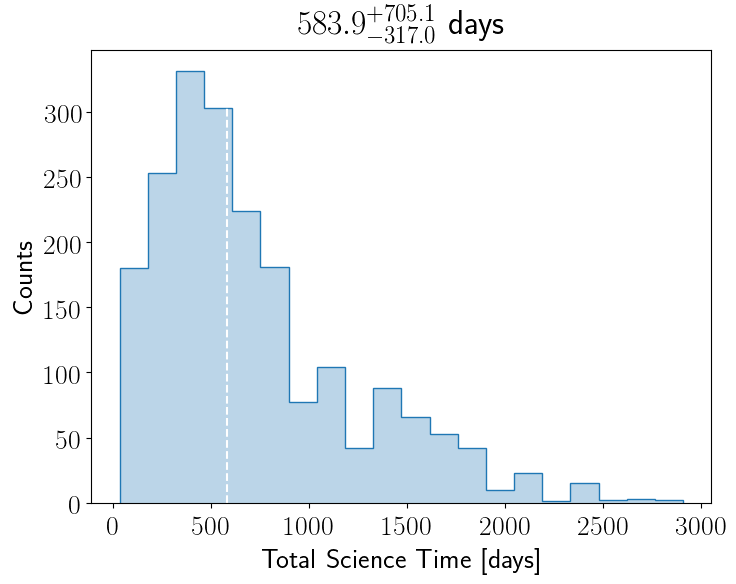

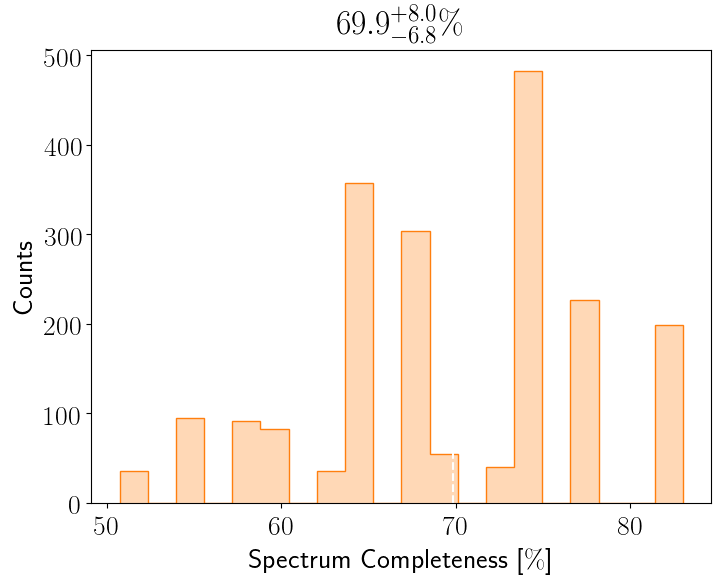

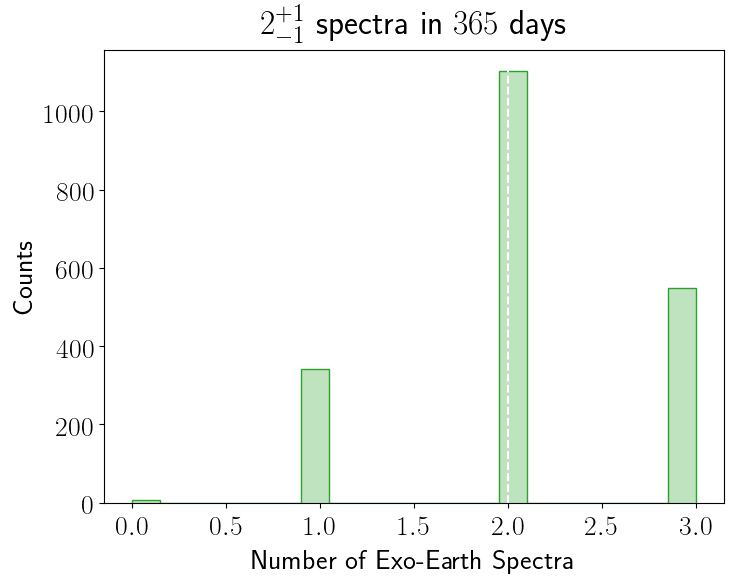

In [86]:
# 3 bands removed
iremove = [0,13]
Xdraw = 2000

# Set RNG seed for reproducible randomness
np.random.seed(seed = 3)

# Run DRM for a single representative output with print statements
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, iremove = iremove, wantexp_days=wantexp)

# Set RNG seed for random sampling
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
c_totx = np.zeros(Xdraw)
countx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx[x] = np.sum(t_tot_sort)
    c_totx[x] = np.mean(c_tot_sort)
    countx[x] = count_in_texp
    
# Plot exposure time hist
color = "C0"
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = color);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot completeness hist
color = "C1"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_totx * 100.)
result = "$%.1f^{+%.1f}_{-%.1f}\%%$" %(q_50, q_p, q_m)
ax.set_xlabel("Spectrum Completeness [$\%$]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(c_totx * 100., bins = 20, alpha = .3, color = color);
ax.hist(c_totx * 100., bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot time-limited program count hist
color = "C2"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(countx)
result = "$%i^{+%i}_{-%i}$ spectra in $%i$ days" %(q_50, q_p, q_m, wantexp)
ax.set_xlabel("Number of Exo-Earth Spectra")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(countx, bins = 20, alpha = .3, color = color);
ax.hist(countx, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

### Test 3) Three bandpasses removed

HIP22263 - G3V - 13.28pc
    - 64.8% Complete Spectrum : 38.96 days
    - UV Spectrum : 5.19 days
    - Optical Spectrum : 38.96 days
    - NIR Spectrum : 33.05 days
    - Overhead 4.46 days
HIP10798 - G8V - 12.67pc
    - 51.7% Complete Spectrum : 30.57 days
    - UV Spectrum : 6.11 days
    - Optical Spectrum : 30.57 days
    - NIR Spectrum : 9.71 days
    - Overhead 3.57 days
HIP36366 - F0V... - 18.05pc
    - 80.4% Complete Spectrum : 508.96 days
    - UV Spectrum : 17.39 days
    - Optical Spectrum : 229.00 days
    - NIR Spectrum : 508.96 days
    - Overhead 51.51 days
---------------------FINAL TALLY---------------------
1.79 yrs for 3 target's complete spectra with overheads (SNR=8)
1.62 yrs for 3 target's complete spectra just science time (SNR=8)
0.17 yrs for 3 target's complete spectra just overheads (SNR=8)
0.08 yrs for 3 target's UV spectra (SNR=8)
0.84 yrs for 3 target's optical spectra (SNR=8)
1.55 yrs for 3 target's NIR spectra (SNR=8)
2 spectra in 77 days (365 desired fo

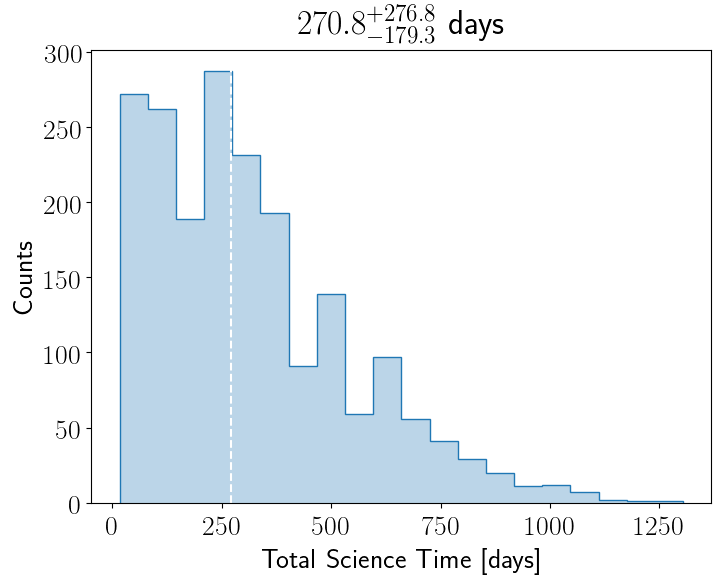

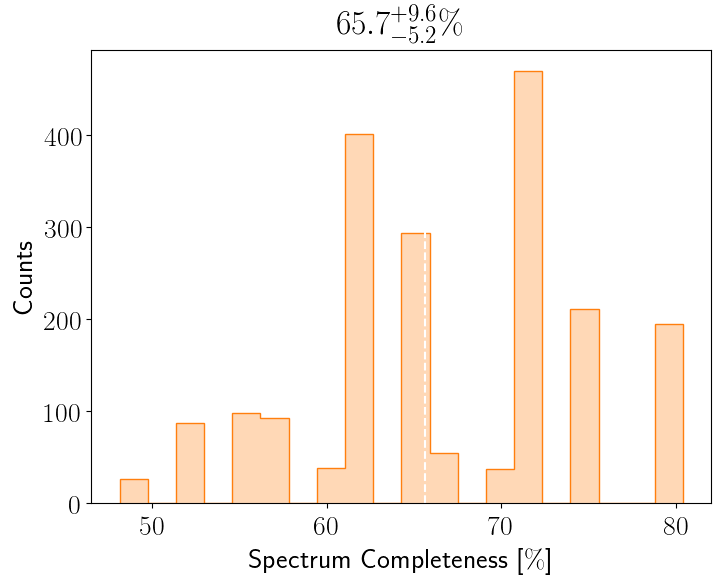

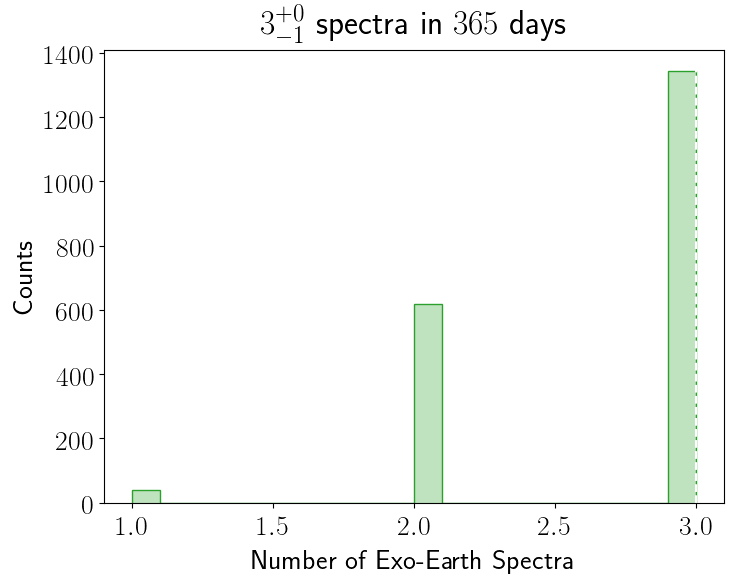

In [93]:
# 3 bands removed
iremove = [0,1,13]
Xdraw = 2000
dt = wantexp

# Set RNG seed for reproducible randomness
np.random.seed(seed = 1)

# Run DRM for a single representative output with print statements
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, iremove = iremove, wantexp_days=dt)

# Set RNG seed for random sampling
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
c_totx = np.zeros(Xdraw)
countx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=dt)
    t_totx[x] = np.sum(t_tot_sort)
    c_totx[x] = np.mean(c_tot_sort)
    countx[x] = count_in_texp
    
# Plot exposure time hist
color = "C0"
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = color);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot completeness hist
color = "C1"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_totx * 100.)
result = "$%.1f^{+%.1f}_{-%.1f}\%%$" %(q_50, q_p, q_m)
ax.set_xlabel("Spectrum Completeness [$\%$]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(c_totx * 100., bins = 20, alpha = .3, color = color);
ax.hist(c_totx * 100., bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot time-limited program count hist
color = "C2"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(countx)
result = "$%i^{+%i}_{-%i}$ spectra in $%i$ days" %(q_50, q_p, q_m, dt)
ax.set_xlabel("Number of Exo-Earth Spectra")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(countx, bins = 20, alpha = .3, color = color);
ax.hist(countx, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

### Test 4) No bandpasses removed, but go for only SNR=1 in the first two UV bands

HIP73184 - K4V - 5.84pc
    - 100.0% Complete Spectrum : 17.16 days
    - UV Spectrum : 17.16 days
    - Optical Spectrum : 2.49 days
    - NIR Spectrum : 3.56 days
    - Overhead 2.49 days
HIP95447 - G8IVvar - 15.18pc
    - 100.0% Complete Spectrum : 260.23 days
    - UV Spectrum : 68.82 days
    - Optical Spectrum : 121.35 days
    - NIR Spectrum : 260.23 days
    - Overhead 26.79 days
HIP86796 - G5V - 15.51pc
    - 56.5% Complete Spectrum : 64.35 days
    - UV Spectrum : 19.37 days
    - Optical Spectrum : 64.35 days
    - NIR Spectrum : 24.15 days
    - Overhead 7.05 days
---------------------FINAL TALLY---------------------
1.06 yrs for 3 target's complete spectra with overheads (SNR=8)
0.96 yrs for 3 target's complete spectra just science time (SNR=8)
0.10 yrs for 3 target's complete spectra just overheads (SNR=8)
0.30 yrs for 3 target's UV spectra (SNR=8)
0.53 yrs for 3 target's optical spectra (SNR=8)
0.81 yrs for 3 target's NIR spectra (SNR=8)
2 spectra in 91 days (365 desired

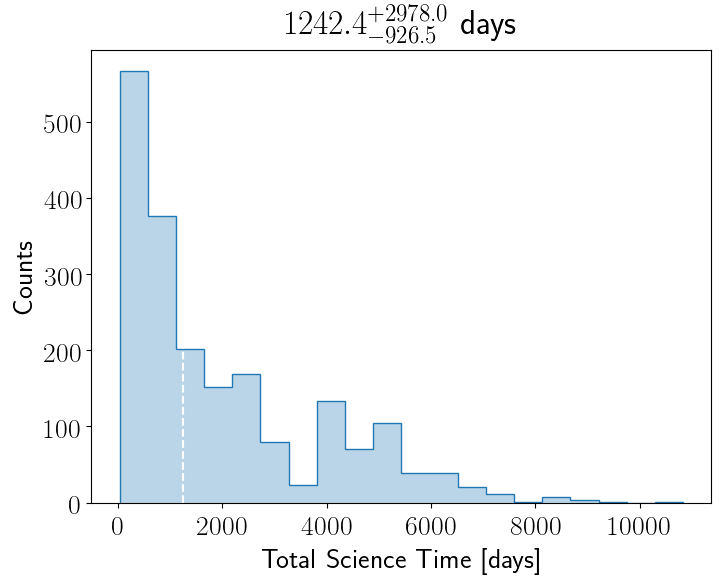

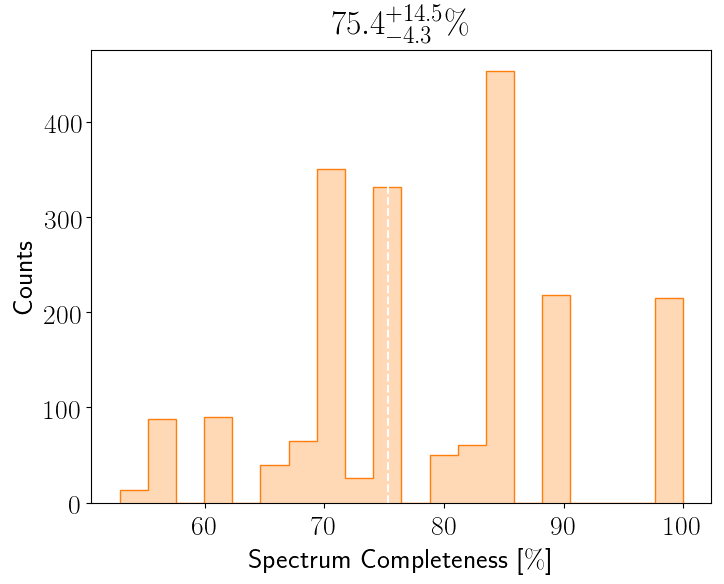

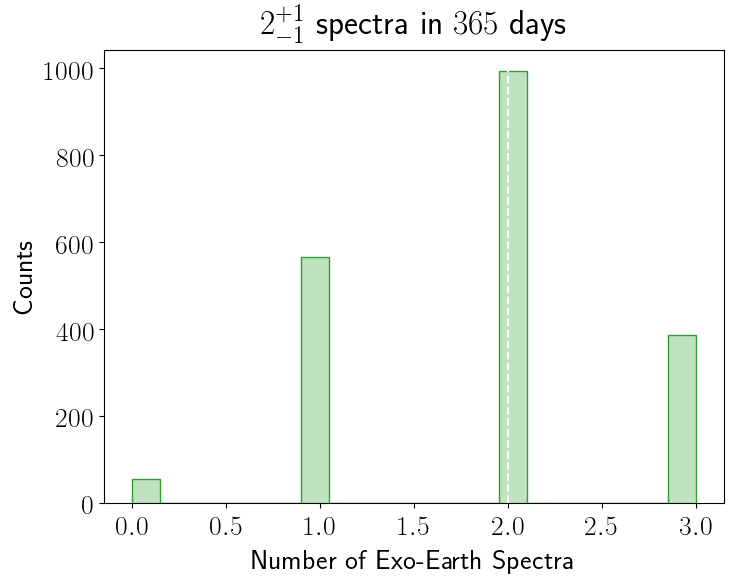

In [50]:
# No bands removed, but scaling SNR for two UV bands
iremove = []
wantSNR_grid = np.array([wantSNR for i in range(len(bp_names))])
wantSNR_grid[0] = 1.0
wantSNR_grid[1] = 1.0
Xdraw = 2000

# Set RNG seed for reproducible randomness
np.random.seed(seed = 0)

# Run DRM for a single representative output with print statements
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, iremove = iremove, wantexp_days=wantexp, wantSNR_grid=wantSNR_grid)

# Set RNG seed for random sampling
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
c_totx = np.zeros(Xdraw)
countx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp, wantSNR_grid=wantSNR_grid)
    t_totx[x] = np.sum(t_tot_sort)
    c_totx[x] = np.mean(c_tot_sort)
    countx[x] = count_in_texp
    
# Plot exposure time hist
color = "C0"
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = color);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot completeness hist
color = "C1"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_totx * 100.)
result = "$%.1f^{+%.1f}_{-%.1f}\%%$" %(q_50, q_p, q_m)
ax.set_xlabel("Spectrum Completeness [$\%$]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(c_totx * 100., bins = 20, alpha = .3, color = color);
ax.hist(c_totx * 100., bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot time-limited program count hist
color = "C2"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(countx)
result = "$%i^{+%i}_{-%i}$ spectra in $%i$ days" %(q_50, q_p, q_m, wantexp)
ax.set_xlabel("Number of Exo-Earth Spectra")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(countx, bins = 20, alpha = .3, color = color);
ax.hist(countx, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

### Test) Only consider the Oxygen A bandpass

HIP36366 - F0V... - 18.05pc
    - 8.1% Complete Spectrum : 91.54 days
    - UV Spectrum : 0.00 days
    - Optical Spectrum : 91.54 days
    - NIR Spectrum : 0.00 days
    - Overhead 9.25 days
HIP98767 - G6IV+... - 16.03pc
    - 8.1% Complete Spectrum : 50.55 days
    - UV Spectrum : 0.00 days
    - Optical Spectrum : 50.55 days
    - NIR Spectrum : 0.00 days
    - Overhead 5.15 days
HIP59199 - F0IV/V - 14.94pc
    - 8.1% Complete Spectrum : 65.54 days
    - UV Spectrum : 0.00 days
    - Optical Spectrum : 65.54 days
    - NIR Spectrum : 0.00 days
    - Overhead 6.65 days
---------------------FINAL TALLY---------------------
0.64 yrs for 3 target's complete spectra with overheads (SNR=8)
0.58 yrs for 3 target's complete spectra just science time (SNR=8)
0.06 yrs for 3 target's complete spectra just overheads (SNR=8)
0.00 yrs for 3 target's UV spectra (SNR=8)
0.58 yrs for 3 target's optical spectra (SNR=8)
0.00 yrs for 3 target's NIR spectra (SNR=8)
2 spectra in 127 days (182 desired for

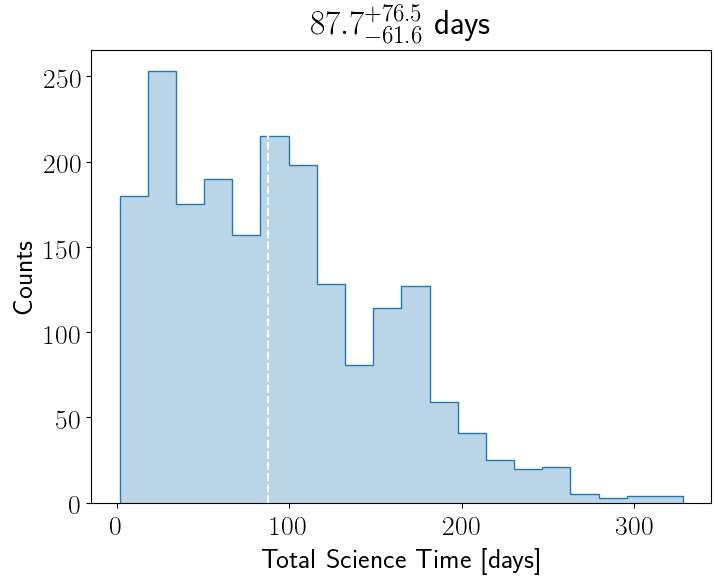

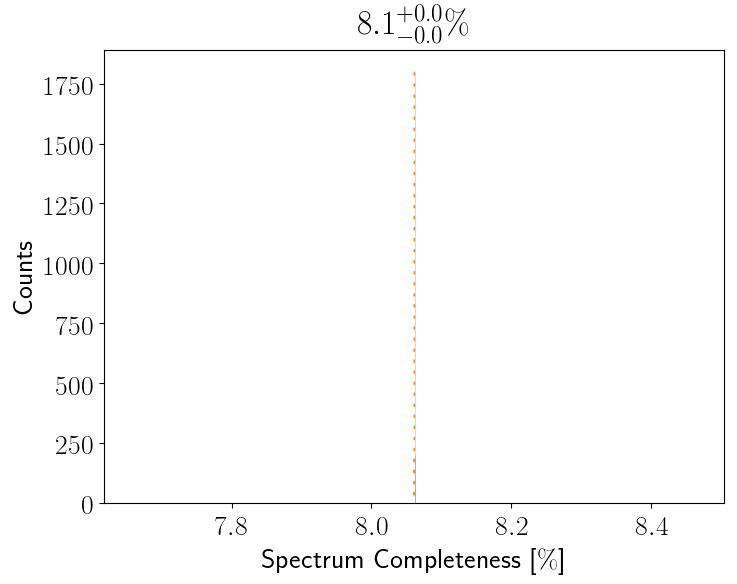

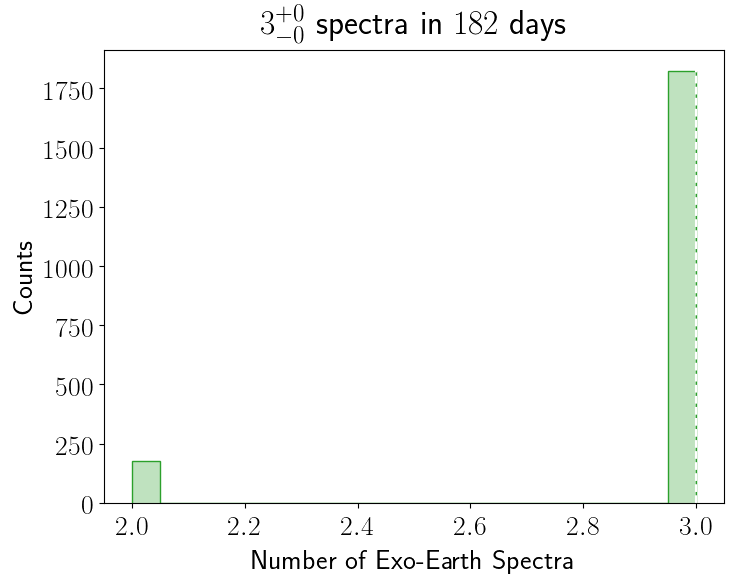

In [71]:
# All except O2-A band
iremove = [0,1,2,3,4,5,6,7,9,10,11,12,13]

# Set RNG seed for reproducible randomness
np.random.seed(seed = 3)

# Run DRM for a single representative output with print statements
t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, iremove = iremove, wantexp_days=dt)

# Set RNG seed for random sampling
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
c_totx = np.zeros(Xdraw)
countx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=dt)
    t_totx[x] = np.sum(t_tot_sort)
    c_totx[x] = np.mean(c_tot_sort)
    countx[x] = count_in_texp
    
# Plot exposure time hist
color = "C0"
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = color);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot completeness hist
color = "C1"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_totx * 100.)
result = "$%.1f^{+%.1f}_{-%.1f}\%%$" %(q_50, q_p, q_m)
ax.set_xlabel("Spectrum Completeness [$\%$]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(c_totx * 100., bins = 20, alpha = .3, color = color);
ax.hist(c_totx * 100., bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot time-limited program count hist
color = "C2"
fig, ax = plt.subplots(1, figsize = (8,6))
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(countx)
result = "$%i^{+%i}_{-%i}$ spectra in $%i$ days" %(q_50, q_p, q_m, dt)
ax.set_xlabel("Number of Exo-Earth Spectra")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(countx, bins = 20, alpha = .3, color = color);
ax.hist(countx, bins = 20, alpha = 1.0, histtype="step", color = color);
ax.axvline(q_50, color = "w", ls = "dashed")

### Test 5) Sensitivity to each eta_interesting star (target prioritization)

star 1: $13^{+29}_{-8}$ days
star 2: $46^{+177}_{-27}$ days
star 3: $399^{+789}_{-285}$ days


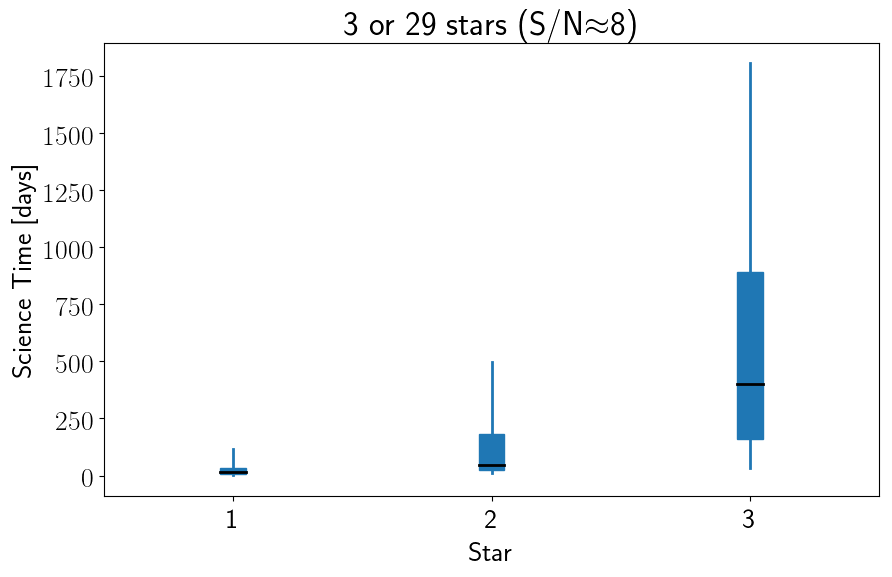

In [51]:
Ndraw = Ndraw_fid
Xdraw = 2000
iremove = [0,1]

np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
t_totx_bp = np.zeros((Xdraw, Ndraw))
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx[x] = np.sum(t_tot_sort)
    t_totx_bp[x,:] = t_tot_sort

fig2, ax2 = plt.subplots(figsize = (10,6))

data = [t_totx_bp[:,i] / 24. for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 1.
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)

#_ = [i.set_color(color1) for i in ax2.get_yticklabels()];

ax2.set_ylabel("Science Time [days]")
ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
#ax2.set_yscale("log")

ax2.set_xlabel("Star")

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1); 

for i in range(t_totx_bp.shape[1]):
    q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_totx_bp[:,i] / 24.)
    result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
    print("star %i: %s days" % (i+1, result))

### Test 6) Sensitivity to removed bandpasses

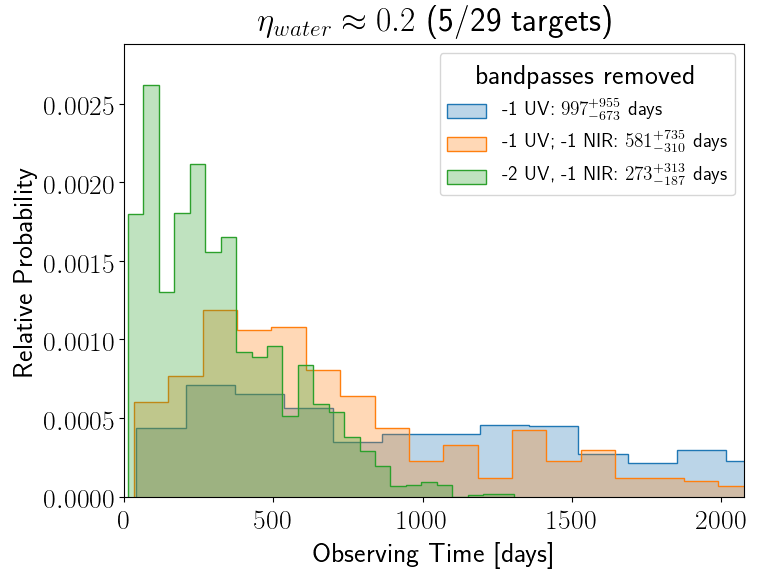

In [87]:
Xdraw = 2000
bins = 25

np.random.seed(seed = None)

# Run DRM for Xdraw number of times
iremove = []
t_totx0 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx0[x] = np.sum(t_tot_sort)
    
# Run DRM for Xdraw number of times
iremove = [0]
t_totx1 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx1[x] = np.sum(t_tot_sort)

# Run DRM for Xdraw number of times
iremove = [0,13]
t_totx2 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx2[x] = np.sum(t_tot_sort)

# Run DRM for Xdraw number of times
iremove = [0,1,13]
t_totx3 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraw_fid, verbose = False, iremove = iremove, wantexp_days=wantexp)
    t_totx3[x] = np.sum(t_tot_sort)

# Plot exposure time hist
fig, ax = plt.subplots(1, figsize = (8,6))
ax.set_xlabel("Observing Time [days]")
ax.set_ylabel("Relative Probability")
ax.set_title(r"$\eta_{water} \approx %.1f $ (%i/%i targets)" %(float(Ndraw)/float(NBIAS), Ndraw, NBIAS))

labels = []
handles = []

"""
label = "complete spectra"
t_totx = t_totx0
color = "C3"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = bins, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = bins, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
#ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)
labels.append(label+": %s days" %result)
"""

label = "-1 UV"
t_totx = t_totx1
color = "C0"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = bins, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = bins, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
#ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)
labels.append(label+": %s days" %result)

ax.set_xlim(left = 0.0, right=0.50*np.max(h[1]))

label = "-1 UV; -1 NIR"
t_totx = t_totx2
color = "C1"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = bins, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = bins, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
#ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)
labels.append(label+": %s days" %result)

label = "-2 UV, -1 NIR"
t_totx = t_totx3
color = "C2"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = bins, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = bins, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
#ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)
labels.append(label+": %s days" %result)

ax.set_ylim(top = 1.1*np.max(h[0]))
ax.legend(handles, labels, fontsize = 14, title = "bandpasses removed")

fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures/drm_arch%s_removing_bands_expose_hist.pdf" %architecture, bbox_inches = "tight")


### Test 7.1) Sensitivity to eta_interesting

In [79]:
iremove = [0,1,13]
Xdraw = 100
Ndraws = np.arange(1,NBIAS)
wantdays = np.linspace(5, 365*2, 20)

zcube = np.zeros((len(Ndraws), len(wantdays), Xdraw))

np.random.seed(seed = None)

for i in range(len(Ndraws)):
    for j in range(len(wantdays)):
        for k in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraws[i], wantexp_days = wantdays[j], verbose = False, iremove = iremove) 
            zcube[i,j,k] = count_in_texp

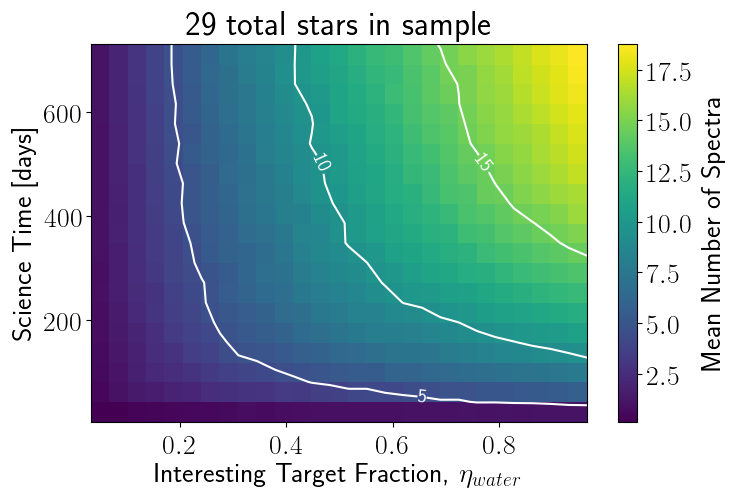

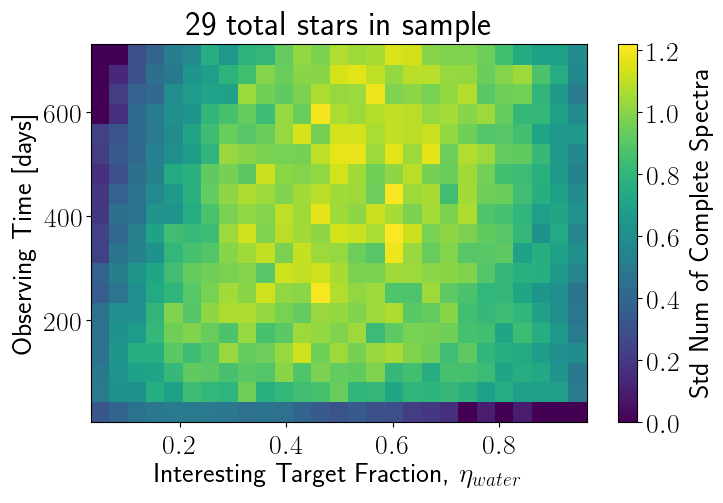

In [81]:
zmean = np.mean(zcube, axis = 2)

contour_intervals = 5.0
levels = list(np.arange(1, zmean.max() / contour_intervals) * contour_intervals)

fig, ax = plt.subplots()
ax.set_title("%i total stars in sample" %NBIAS)
ax.set_xlabel("Interesting Target Fraction, $\eta_{water}$")
ax.set_ylabel("Science Time [days]")
p = ax.pcolor(Ndraws / float(NBIAS), wantdays, zmean.T)
cln = ax.contour(Ndraws / float(NBIAS), wantdays, zmean.T, colors="w", levels = levels)
plt.clabel(cln, inline=1, fontsize=14, inline_spacing=1, fmt = "%i")
fig.colorbar(p, label = "Mean Number of Spectra")
p.set_rasterized(True)
fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures/drm_arch%s_time_vs_eta_case4.pdf" %architecture, bbox_inches = "tight")

zstd = np.std(zcube, axis = 2)

fig, ax = plt.subplots()
ax.set_title("%i total stars in sample" %NBIAS)
ax.set_xlabel("Interesting Target Fraction, $\eta_{water}$")
ax.set_ylabel("Observing Time [days]")
p = ax.pcolor(Ndraws / float(NBIAS), wantdays, zstd.T)
fig.colorbar(p, label = "Std Num of Complete Spectra")

### Test 7.2) Sensitivity to science program duration

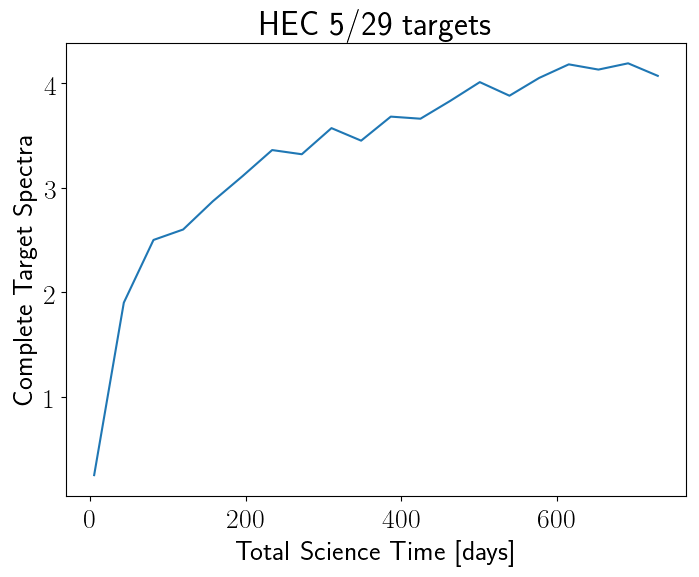

In [55]:
Ndraw = 5
idraw = np.argmin(np.fabs(Ndraw - Ndraws))

fig, ax = plt.subplots(1, figsize = (8,6))
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Complete Target Spectra")
ax.set_title("HEC %i/%i targets" %(Ndraw, NBIAS))
ax.plot(wantdays, np.mean(zcube[idraw,:,:], axis = 1))

## Make a table of exposure time vs eta_interesting

In [88]:
# 1-year program
Xdraw = 2000
dt = 365.
etas = np.array([0.1, 0.2, 0.5, 1.0])
Ndraws = np.array(np.round(etas*NBIAS), dtype=int)
cases = [[], [0], [0,1], [0,1,13], [0,1,2,3,4,5,6,7,9,10,11,12,13]]

# Run DRM for Xdraw number of times
t_totx = np.zeros((len(Ndraws), len(cases), 3))
t_scix = np.zeros((len(Ndraws), len(cases), 3))
t_ovrx = np.zeros((len(Ndraws), len(cases), 3))
countx = np.zeros((len(Ndraws), len(cases), 3))
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        t_tmp = np.zeros(Xdraw)
        t_sci = np.zeros(Xdraw)
        t_ovr = np.zeros(Xdraw)
        c_tmp = np.zeros(Xdraw)
        for x in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraws[i], verbose = False, iremove = cases[j], wantexp_days=dt)
            t_tmp[x] = np.sum(t_tot_sort[:count_in_texp]) / 24.
            t_sci[x] = np.sum(t_sci_sort[:count_in_texp]) / 24.
            t_ovr[x] = np.sum(t_ovr_sort[:count_in_texp]) / 24.
            c_tmp[x] = count_in_texp
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_tmp)
        t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_sci)
        t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_ovr)
        t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_tmp)
        countx[i,j,0], countx[i,j,1], countx[i,j,2] = q_50, q_p, q_m

In [89]:
print("------ Number of Spectra in %.1f days ------" %dt)
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        print("N=%i, case=%s : $%i^{+%i}_{-%i}$ spectra" %(Ndraws[i], cases[j], countx[i,j,0], countx[i,j,1], countx[i,j,2]))
        
print("------ Exposure time [days] total, science, overhead ------")
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        print("N=%i, case=%s : $%.1f^{+%.1f}_{-%.1f}$, $%.1f^{+%.1f}_{-%.1f}$, $%.1f^{+%.1f}_{-%.1f}$" %(Ndraws[i], cases[j], 
                                                                                                         t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2], 
                                                                                                         t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2], 
                                                                                                         t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2]))

------ Number of Spectra in 365.0 days ------
N=3, case=[] : $1^{+0}_{-1}$ spectra
N=3, case=[0] : $2^{+1}_{-1}$ spectra
N=3, case=[0, 1] : $2^{+1}_{-0}$ spectra
N=3, case=[0, 1, 13] : $3^{+0}_{-1}$ spectra
N=3, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $3^{+0}_{-0}$ spectra
N=6, case=[] : $1^{+1}_{-0}$ spectra
N=6, case=[0] : $3^{+1}_{-1}$ spectra
N=6, case=[0, 1] : $4^{+1}_{-1}$ spectra
N=6, case=[0, 1, 13] : $5^{+1}_{-1}$ spectra
N=6, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $6^{+0}_{-0}$ spectra
N=14, case=[] : $2^{+0}_{-1}$ spectra
N=14, case=[0] : $6^{+1}_{-1}$ spectra
N=14, case=[0, 1] : $9^{+1}_{-2}$ spectra
N=14, case=[0, 1, 13] : $9^{+2}_{-1}$ spectra
N=14, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $13^{+1}_{-1}$ spectra
N=29, case=[] : $3^{+0}_{-0}$ spectra
N=29, case=[0] : $10^{+0}_{-0}$ spectra
N=29, case=[0, 1] : $15^{+0}_{-0}$ spectra
N=29, case=[0, 1, 13] : $16^{+0}_{-0}$ spectra
N=29, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $23^{+

In [90]:
# 0.5-year program
Xdraw = 2000
dt = 365. / 2.
etas = np.array([0.1, 0.2, 0.5, 1.0])
Ndraws = np.array(np.round(etas*NBIAS), dtype=int)
cases = [[], [0], [0,1], [0,1,13], [0,1,2,3,4,5,6,7,9,10,11,12,13]]

# Run DRM for Xdraw number of times
t_totx = np.zeros((len(Ndraws), len(cases), 3))
t_scix = np.zeros((len(Ndraws), len(cases), 3))
t_ovrx = np.zeros((len(Ndraws), len(cases), 3))
countx = np.zeros((len(Ndraws), len(cases), 3))
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        t_tmp = np.zeros(Xdraw)
        t_sci = np.zeros(Xdraw)
        t_ovr = np.zeros(Xdraw)
        c_tmp = np.zeros(Xdraw)
        for x in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = run_hec_drm(Ndraw = Ndraws[i], verbose = False, iremove = cases[j], wantexp_days=dt)
            t_tmp[x] = np.sum(t_tot_sort[:count_in_texp]) / 24.
            t_sci[x] = np.sum(t_sci_sort[:count_in_texp]) / 24.
            t_ovr[x] = np.sum(t_ovr_sort[:count_in_texp]) / 24.
            c_tmp[x] = count_in_texp
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_tmp)
        t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_sci)
        t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_ovr)
        t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_tmp)
        countx[i,j,0], countx[i,j,1], countx[i,j,2] = q_50, q_p, q_m

In [91]:
print("------ Number of Spectra in %.1f days ------" %dt)
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        print("N=%i, case=%s : $%i^{+%i}_{-%i}$ spectra" %(Ndraws[i], cases[j], countx[i,j,0], countx[i,j,1], countx[i,j,2]))
        
print("------ Exposure time [days] total, science, overhead ------")
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        print("N=%i, case=%s : $%.1f^{+%.1f}_{-%.1f}$, $%.1f^{+%.1f}_{-%.1f}$, $%.1f^{+%.1f}_{-%.1f}$" %(Ndraws[i], cases[j], 
                                                                                                         t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2], 
                                                                                                         t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2], 
                                                                                                         t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2]))

------ Number of Spectra in 182.5 days ------
N=3, case=[] : $0^{+1}_{-0}$ spectra
N=3, case=[0] : $1^{+1}_{-0}$ spectra
N=3, case=[0, 1] : $2^{+1}_{-1}$ spectra
N=3, case=[0, 1, 13] : $2^{+1}_{-1}$ spectra
N=3, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $3^{+0}_{-0}$ spectra
N=6, case=[] : $1^{+0}_{-1}$ spectra
N=6, case=[0] : $2^{+1}_{-0}$ spectra
N=6, case=[0, 1] : $3^{+1}_{-0}$ spectra
N=6, case=[0, 1, 13] : $4^{+1}_{-1}$ spectra
N=6, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $6^{+0}_{-1}$ spectra
N=14, case=[] : $1^{+0}_{-0}$ spectra
N=14, case=[0] : $4^{+1}_{-0}$ spectra
N=14, case=[0, 1] : $7^{+1}_{-1}$ spectra
N=14, case=[0, 1, 13] : $8^{+1}_{-1}$ spectra
N=14, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $11^{+1}_{-1}$ spectra
N=29, case=[] : $1^{+0}_{-0}$ spectra
N=29, case=[0] : $7^{+0}_{-0}$ spectra
N=29, case=[0, 1] : $11^{+0}_{-0}$ spectra
N=29, case=[0, 1, 13] : $12^{+0}_{-0}$ spectra
N=29, case=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] : $19^{+0

## What does a representative observed spectrum look like?

In [60]:
cn.wantsnr

10.0

In [61]:
def get_lam_dlam(cn):
    """
    """
    
    # Make a copy to ensure were not changing the original
    cnc = copy.deepcopy(cn)
    
    # Run count rates (necessary to generate new wavelength grid)
    cnc.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
    
    return cnc.lam, cnc.dlam

def complete_spectrum_time(cn, Ahr_flat = 0.2, wantSNR = 10.0, bandwidth = 0.2, architecture = "A", 
                           plot = False, verbose = False):
    """
    Time for a complete spectrum

    Parameters
    ----------
    Ahr_flat : float
        Flat albedo spectrum
    wanrSNR : float or array-like
        Desired SNR on spectrum (per bandpass if array-like)
    plot : bool
        Produce a plot?
    verbose : bool
        Print things?

    Returns
    -------
    t_tot : array-like
        total exposure time
    t_per_band_per_chan : list
        time per band per channel
    spectrum : tuple
        (lam, Cratio, Cobs, Csig)
    iwa : tuple
        (pct_obs_iwa, lammax_obs_iwa)

    """
    
    fstar = cn.solhr
    
    if plot: fig, ax = plt.subplots()

    cc = ["C0", "C2", "C3"]
    t_chan = np.zeros(len(spectroscopy.CHANNELS))
    Nbands_per_chan = np.zeros(len(spectroscopy.CHANNELS))
    t_per_band_per_chan = []
    full_lam = []
    full_dlam = []
    full_Cobs = []
    full_Cratio = []
    full_Csig = []
    pct_obs_iwa = []
    lammax_obs_iwa = []
    lam_extrema = []
    
    ibp = 0

    # Loop over telescope channels
    for j, channel in enumerate(spectroscopy.CHANNELS):

        t_tmp = []

        # Get the channel specific telescope parameters
        luvoir = spectroscopy.default_luvoir(channel=channel, architecture = architecture)
        cn.telescope = luvoir

        if verbose: print(channel, luvoir.lammin, luvoir.lammax)

        lam_extrema.append(luvoir.lammin)
        lam_extrema.append(luvoir.lammax)

        # Calculate the bandpass edges
        edges = spectroscopy.calculate_bandpass_edges(luvoir.lammin, luvoir.lammax, bandwidth = bandwidth)

        # Calculate the number of bandpasses
        Nbands = len(edges) - 1
        Nbands_per_chan[j] = Nbands

        # Run count rates (necessary to generate new wavelength grid)
        #cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
        
        # Get new wavelength grid
        l_grid, dl_grid = get_lam_dlam(cn)

        # Calculate how much of the spectrum is observable
        cnc = copy.deepcopy(cn)
        cnc.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
        pct, lammax_obs = spectroscopy.calc_observable_spectrum(cnc)
        pct_obs_iwa.append(pct)
        lammax_obs_iwa.append(lammax_obs)

        # Loop over bandpasses
        for i in range(Nbands):
            
            if (type(wantSNR) is float) or (type(wantSNR) is int):
                wSNR = wantSNR
            else:
                wSNR = wantSNR[ibp]

            # Get the max, min, and middle wavelenths for this bandpass
            lammin = edges[i]
            lammax = edges[i+1]
            lammid = 0.5*(lammax + lammin)

            # Set telescope wavelength range
            cn.telescope.lammin = lammin
            cn.telescope.lammax = lammax

            if channel == "UV":
                cn.telescope.lam = np.array([lammid])
                cn.telescope.dlam = np.array([lammax - lammin])

            # Set spectrum to use for exposure time calcs
            # Using flat spectrum so not biased by bottom of bands
            Ahr_flat  = Ahr_flat * np.ones(len(spectroscopy.LAMHR))

            # Run count rates (necessary to generate new wavelength grid)
            cn.run_count_rates(Ahr_flat, spectroscopy.LAMHR, fstar)

            # Calculate exposure times to wantSNR
            etimes = spectroscopy.determine_exposure_time(cn, None, plot_snr_curves=False,
                        plot_spectrum=False, wantSNR=wSNR, ref_lam = lammid)
            t_ref_lam = etimes[-1]

            # Re-do count rate calcs for true Earth spectrum
            cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, fstar)

            # Draw random samples of data for a plot
            cn.make_fake_data(texp=t_ref_lam)

            if verbose: print(lammid, t_ref_lam)

            # Plot
            if plot:
                ax.axvspan(lammin, lammax, alpha = 0.2, color = cc[j])
                #ax.plot(cn.lam, cn.Cratio, ls = "steps-mid", color = "grey", zorder = 100)
                ax.plot(cn.lam, cn.Cobs, "o", ms = 3.0, alpha = 1.0, color = "w", zorder = 70)
                ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "o", ms = 2.0, alpha = 0.7, color = "k", zorder = 70)
                ax.set_xlabel("Wavelength [$\mu$m]")
                ax.set_ylabel("$F_p / F_s$")

            # Save values
            t_tmp.append(t_ref_lam)
            full_lam.append(cn.lam)
            full_dlam.append(cn.dlam)
            full_Cratio.append(cn.Cratio)
            full_Cobs.append(cn.Cobs)
            full_Csig.append(cn.Csig)

            # Add time
            if np.isfinite(t_ref_lam):
                t_chan[j] += t_ref_lam
                
            ibp += 1

        # Save tmp times per band
        t_per_band_per_chan.append(t_tmp)

    # Deal with the "two channels at a time" thing
    t_tot = spectroscopy.apply_two_channels(t_chan)

    spectrum = (np.array(full_lam),
                np.array(full_dlam),
                np.array(full_Cratio),
                np.array(full_Cobs),
                np.array(full_Csig))
    iwa = (pct_obs_iwa, lammax_obs_iwa)

    if plot:
        lam_extrema = np.array(lam_extrema)
        cn.telescope.lammin = np.min(lam_extrema)
        cn.telescope.lammax = np.max(lam_extrema)
        cn.telescope.resolution = 140.
        # Re-do count rate calcs for true Earth spectrum
        cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
        ax.plot(cn.lam, cn.Cratio, color = "grey", zorder = 80, lw = 3.0)
        ax.plot(cn.lam, cn.Cratio, color = "w", zorder = 80, lw = 2.0)

    return t_tot, t_per_band_per_chan, spectrum, iwa

In [62]:
# Set planet and star parameters for an Earth-Sun analog at 5pc
cn.planet.distance = 5.0
cn.planet.a = 1.0
cn.star.Rs = 1.0
cn.star.Teff = 5780.

wantSNR_grid = np.array([wantSNR for i in range(len(bp_names))])
wantSNR_grid[0] = 1.0
wantSNR_grid[1] = 1.0

output = spectroscopy.complete_spectrum_time(cn, Ahr_flat = Ahr_flat, wantSNR = wantSNR, bandwidth = bandwidth,
                       plot = False, verbose = False)
spectrum = output[2]

In [63]:
# Sum to get average time per bandpass
tmp = np.nansum(tpbpcx, axis=1).T
#tmp = tpbpcs_rect.reshape((tpbpcs_rect.shape[1], tpbpcs_rect.shape[0]))

In [64]:
frac_bias_bp

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.96551724, 0.62068966, 0.48275862, 0.48275862])

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


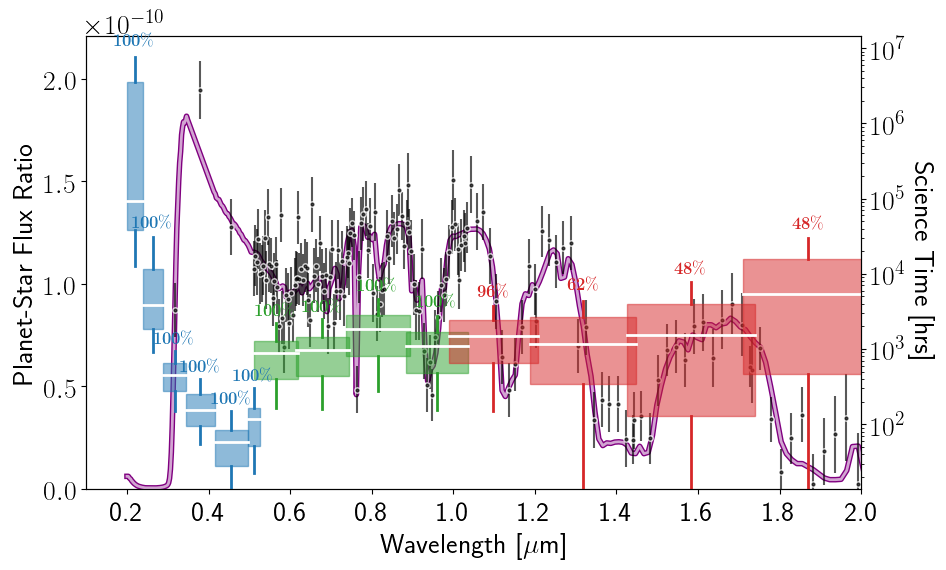

In [65]:
iremove = []
cc = ["C0", "C2", "C3"]
plot_boxes = True

fig, ax = plt.subplots(figsize = (10,6))

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Planet-Star Flux Ratio")
for i in range(len(bp_names)):
    if i not in iremove:
        ax.plot(spectrum[0][i], spectrum[3][i], "o", ms = 4.0, alpha = 0.65, color = "w", zorder = 80)
        ax.errorbar(spectrum[0][i], spectrum[3][i], yerr=spectrum[4][i], fmt = "o", ms = 2.0, alpha = 0.65, color = "k", zorder = 80)

cn.telescope.lammin = 0.2
cn.telescope.lammax = 2.0
cn.telescope.resolution = 140.
# Re-do count rate calcs for true Earth spectrum
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
ax.plot(cn.lam, cn.Cratio, color = "purple", zorder = 70, lw = 4.0, alpha = 1.)
ax.plot(cn.lam, cn.Cratio, color = "w", zorder = 70, lw = 2.0, alpha = 0.65)
ax.set_ylim(bottom=0.0)

if plot_boxes:

    ax2 = ax.twinx()
    
    """
    Xdraw = len(tpbpcs_draws_tots[0][0])

    # Transform quantities for boxplot
    tmp = [np.zeros((len(tpbpcs_draws_tots[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
    for i in range(Xdraw):
        for j in range(tp):
            for k in range(len(tpbpcs_draws_tots[j])):
                tmp[j][k,i] = tpbpcs_draws_tots[j][k][i]
    """

    icount = 0
    for ichan in range(len(spectroscopy.CHANNELS)):
        
        data = []
        positions = []
        widths = []
        
        for j in range(len(bp_names[bp_chan == ichan])):
                
            data.append(tmp[icount,:])
            positions.append(np.mean(spectrum[0][icount]))
            widths.append(spectrum[0][icount][-1] - spectrum[0][icount][0] + np.mean(spectrum[1][icount][:]))
            color1 = cc[ichan]

            comp_str = "$%i \%%$" %(100.*frac_bias_bp[icount])
            comp_str2 = "$\mathbf{%i \%%}$" %(100.*frac_bias_bp[icount])
            #ax2.text(positions[j], np.median(tmp[icount,:]) + 5.*np.std(tmp[icount,:]), comp_str2, 
            #         ha = "center", va = "top", fontsize = 12, color = "w")
            ax2.text(positions[j], np.median(tmp[icount,:]) + 5.*np.std(tmp[icount,:]), comp_str2, 
                     ha = "center", va = "top", fontsize = 12, color = color1)

            icount += 1

        positions = np.array(positions)
        widths = np.array(widths)
        bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                          boxprops = {"color" : color1, "alpha" : 0.5}, 
                          whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                          capprops = {"color" : color1, "linewidth" : 0.0}, 
                          medianprops = {"color" : "w", "linewidth" : 2.0}, 
                          patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)

    ax2.set_ylabel("Science Time [hrs]", labelpad = 22, rotation = 270)
    #ax2.set_title(r"All %i targets (S/N$\approx$%i)" %(Ndraw, wantSNR))
    ax2.set_yscale("log")

    ax2.set_xlabel("Wavelength [$\mu$m]")
    ax2.set_ylim(bottom = 0.0)

    ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xlim(0.1, 2.0)
    #ax2.set_xlim(0.4, 1.0)

fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures/drm_arch%s_test.pdf" %architecture, bbox_inches = "tight")

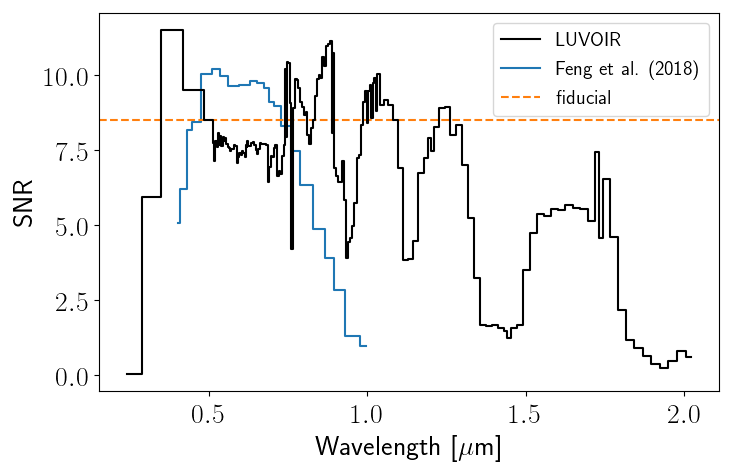

In [66]:
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("SNR")
x = []
y = []
for i in range(len(bp_names)):
    if i not in iremove:
        x.append(spectrum[0][i])
        y.append(spectrum[2][i]/spectrum[4][i])
        
x = np.hstack(x)
y = np.hstack(y)

isort = np.argsort(x)

ax.plot(x[isort], y[isort], alpha = 1.0, color = "k", zorder = 70, label = "LUVOIR", ls="steps-mid")
ax.plot(lam_snr_feng, snr_lam_feng*10., label = "Feng et al. (2018)", ls="steps-mid")
ax.axhline(wantSNR, ls = "--", color = "C1", label = "fiducial")

ax.legend(fontsize = 14)